In [47]:
from tqdm.notebook import tqdm
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import date
import os

import warnings
warnings.filterwarnings('ignore')


In [48]:
base_path = 'data/created/'
futures_huobi = pd.read_csv(base_path + 'futures_huobi.tsv', index_col=0, sep='\t')
futures_bitmex = pd.read_csv(base_path + 'futures_bitmex.tsv', index_col=0, sep='\t')
spot = pd.read_csv(base_path + 'spot.tsv', index_col=0, sep='\t')
ccmix_index = pd.read_csv('data/index/CCMIXdata.csv', parse_dates=['Date'], index_col=['Date'], usecols=['Date', 'CCMIX'])
risk_free = pd.read_csv('data/index/risk_free.csv', parse_dates=['DATE'], index_col=['DATE']) 


# Переводим индексы в датаобъекты
futures_huobi.index = pd.to_datetime(futures_huobi.index)

futures_bitmex.index = pd.to_datetime(futures_bitmex.index)

ccmix_index.index = ccmix_index.index.normalize()
ccmix_index['rolling_10'] = ccmix_index['CCMIX'].rolling(10).mean()
ccmix_index['rolling_20'] = ccmix_index['CCMIX'].rolling(20).mean()
ccmix_index['dummy'] = (ccmix_index['rolling_10'] > ccmix_index['rolling_20']).astype(int)
ccmix_index['return'] = ccmix_index['CCMIX'].pct_change().fillna(0)

spot.index = pd.to_datetime(spot.index)

risk_free = risk_free.resample('1d').last().fillna(method='ffill') / 100
risk_free.columns = ['risk_free']
ix = pd.date_range(start='2013-01-01', end='2021-12-31', freq='D')
risk_free = risk_free.reindex(ix).fillna(method='ffill')

In [49]:
spot.reset_index().pivot(index='index', columns=['coin'])['price'].loc[all_carry.index]

coin             ADA         BCH  BFX         BSV           BTC        DOT  \
index                                                                        
2018-11-08  0.078971  620.564604  NaN         NaN   6574.801180        NaN   
2018-11-09  0.076996  577.779650  NaN         NaN   6490.454731        NaN   
2018-11-10  0.074665  546.439496  NaN   70.605541   6413.782039        NaN   
2018-11-11  0.075374  555.894508  NaN   85.702931   6429.898792        NaN   
2018-11-12  0.076823  535.239190  NaN  114.138635   6434.284597        NaN   
...              ...         ...  ...         ...           ...        ...   
2021-04-30  1.315126         NaN  NaN         NaN  53596.704023  35.781688   
2021-05-01  1.353730         NaN  NaN         NaN  57828.511814  36.555817   
2021-05-02  1.353729         NaN  NaN         NaN  57812.969160  36.895496   
2021-05-03  1.328089         NaN  NaN         NaN  56600.745287  36.628563   
2021-05-04  1.359143         NaN  NaN         NaN  57200.300299  37.310868   

coin             EOS          ETH       FCT  FIL  ...         NEO       TRX  \
index                                             ...                         
2018-11-08  5.677290   219.015775  4.629028  NaN  ...   16.800898  0.024159   
2018-11-09  5.541045   213.407634  4.571980  NaN  ...   16.414930  0.023309   
2018-11-10  5.403594   210.790620  4.364963  NaN  ...   16.011294  0.023066   
2018-11-11  5.431578   212.965828  4.450228  NaN  ...   15.992922  0.023055   
2018-11-12  5.483691   212.473325  4.337877  NaN  ...   16.003509  0.022917   
...              ...          ...       ...  ...  ...         ...       ...   
2021-04-30  5.879895  2757.497552       NaN  NaN  ...   89.493342       NaN   
2021-05-01  6.440605  2776.703712       NaN  NaN  ...   97.069913       NaN   
2021-05-02  6.617538  2944.916947       NaN  NaN  ...  102.242551       NaN   
2021-05-03  6.541372  2953.297348       NaN  NaN  ...  106.498950       NaN   
2021-05-04  6.816642  3439.855070       NaN  NaN  ...  107.294141       NaN   

coin        WIN       XBC  XBTC       XLM         XMR       XRP       XTZ  \
index                                                                       
2018-11-08  NaN  6.131251   NaN  0.258307  111.836181  0.539121  1.334380   
2018-11-09  NaN  6.557548   NaN  0.258279  109.690941  0.496651  1.323691   
2018-11-10  NaN  6.281709   NaN  0.256990  107.514408  0.502569  1.298285   
2018-11-11  NaN  6.467820   NaN  0.262062  105.932730  0.508053  1.311773   
2018-11-12  NaN  7.038131   NaN  0.275238  106.510842  0.508786  1.325419   
...         ...       ...   ...       ...         ...       ...       ...   
2021-04-30  NaN       NaN   NaN       NaN         NaN       NaN       NaN   
2021-05-01  NaN       NaN   NaN       NaN         NaN       NaN       NaN   
2021-05-02  NaN       NaN   NaN       NaN         NaN       NaN       NaN   
2021-05-03  NaN       NaN   NaN       NaN         NaN       NaN       NaN   
2021-05-04  NaN       NaN   NaN       NaN         NaN       NaN       NaN   

coin               ZEC  
index                   
2018-11-08  129.030479  
2018-11-09  138.213569  
2018-11-10  134.703056  
2018-11-11  131.112541  
2018-11-12  129.669876  
...                ...  
2021-04-30         NaN  
2021-05-01         NaN  
2021-05-02         NaN  
2021-05-03         NaN  
2021-05-04         NaN  

[909 rows x 23 columns]

In [50]:
def pivot(df, column='ar_carry'):
    pivoted = df.reset_index().pivot(index='index', columns=['coin'])
    return pivoted[column]


all_carry = pivot(futures_huobi[futures_huobi['length'] == 'week'])
all_price =  pivot(spot, 'price').loc[all_carry.index]
market_price = (1 + all_price.pct_change().mean(axis=1)).cumprod()

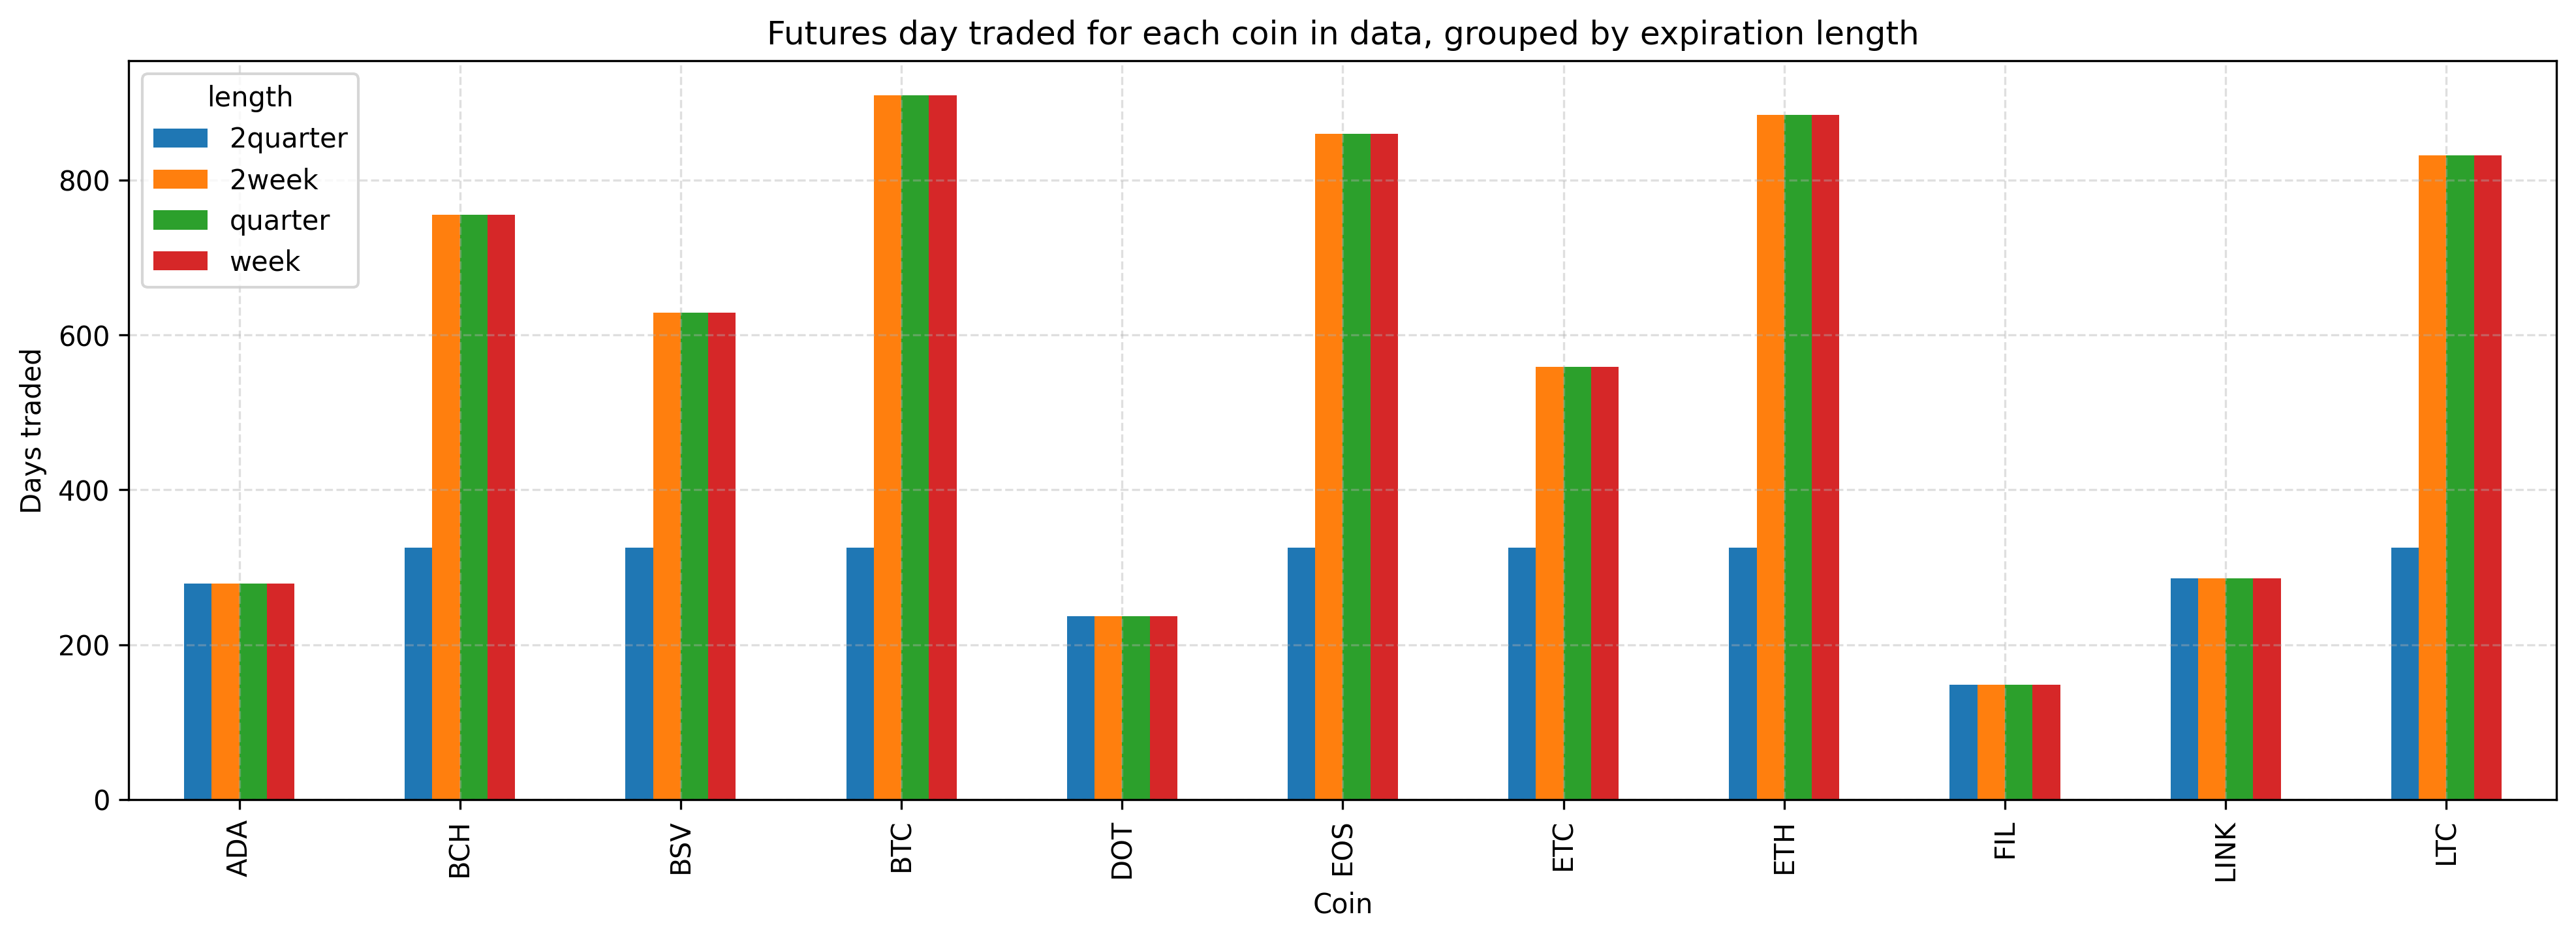

In [51]:
f, ax = plt.subplots(figsize=(16, 5), dpi=300)


futures_huobi.groupby(['coin', 'length']).count()['count'].unstack().plot.bar(ax=ax, title='Futures day traded for each coin in data, grouped by expiration length', xlabel='Coin', ylabel='Days traded');
ax.grid(alpha=0.4, ls='--')

plt.savefig('imgs/huobi_spot.png')

In [52]:
all_carry

coin             ADA  BCH  BSV       BTC       DOT       EOS  ETC       ETH  \
index                                                                         
2018-11-08       NaN  NaN  NaN -0.057006       NaN       NaN  NaN       NaN   
2018-11-09       NaN  NaN  NaN -0.018147       NaN       NaN  NaN       NaN   
2018-11-10       NaN  NaN  NaN -0.014277       NaN       NaN  NaN       NaN   
2018-11-11       NaN  NaN  NaN -0.005935       NaN       NaN  NaN       NaN   
2018-11-12       NaN  NaN  NaN -0.015639       NaN       NaN  NaN       NaN   
...              ...  ...  ...       ...       ...       ...  ...       ...   
2021-04-30  0.015764  NaN  NaN  0.074899  0.020902  0.093727  NaN  0.045679   
2021-05-01 -0.012192  NaN  NaN -0.016547 -0.000876  0.001459  NaN  0.059720   
2021-05-02 -0.004205  NaN  NaN  0.000161  0.009923  0.011554  NaN  0.076993   
2021-05-03 -0.040469  NaN  NaN -0.047608 -0.034950 -0.016720  NaN  0.094116   
2021-05-04  0.015576  NaN  NaN -0.022243  0.042117  0.116532  NaN -0.021564   

coin        FIL      LINK       LTC  
index                                
2018-11-08  NaN       NaN       NaN  
2018-11-09  NaN       NaN       NaN  
2018-11-10  NaN       NaN       NaN  
2018-11-11  NaN       NaN       NaN  
2018-11-12  NaN       NaN       NaN  
...         ...       ...       ...  
2021-04-30  NaN  0.083014  0.057672  
2021-05-01  NaN  0.037688 -0.006453  
2021-05-02  NaN -0.011850  0.026783  
2021-05-03  NaN  0.078945  0.107116  
2021-05-04  NaN  0.154181  0.186818  

[909 rows x 11 columns]

In [165]:
(1 + all_carry).cumprod().iloc[from_: to, :][symbol]

index
2020-12-06     2.868780
2020-12-07     2.795619
2020-12-08     2.672376
2020-12-09     2.644727
2020-12-10     2.584218
                ...    
2021-04-29    23.793492
2021-04-30    25.575604
2021-05-01    25.152403
2021-05-02    25.156445
2021-05-03    23.958807
Name: BTC, Length: 149, dtype: float64

In [167]:
all_price.iloc[from_: to, :][symbol].shift(-1)

index
2020-12-06    19325.554119
2020-12-07    19198.806494
2020-12-08    18336.514581
2020-12-09    18564.986456
2020-12-10    18262.058385
                  ...     
2021-04-29    53596.704023
2021-04-30    57828.511814
2021-05-01    57812.969160
2021-05-02    56600.745287
2021-05-03             NaN
Name: BTC, Length: 149, dtype: float64

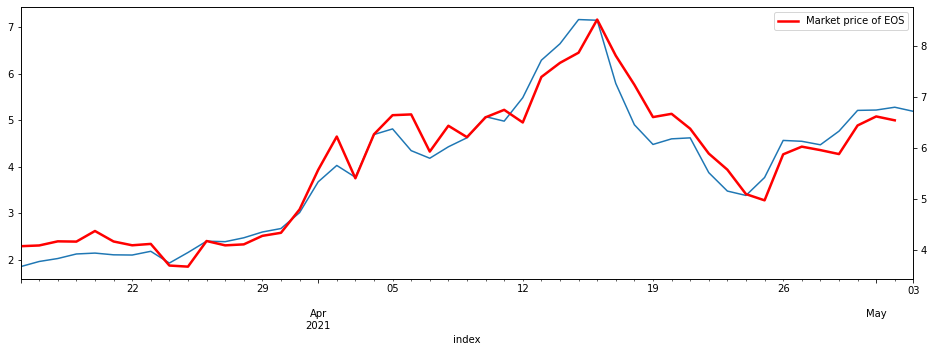

In [171]:
# Вот тут полный разъеб

f, ax = plt.subplots(figsize=(16,5))

from_ = -50
to = -1

symbol = 'EOS'

(1 + all_carry).cumprod().iloc[from_: to, :][symbol].plot(ax=ax, label='Factor')
ax2 = ax.twinx()
all_price.iloc[from_: to, :][symbol].shift(-1).plot(ax=ax2, c='r', lw='2.5', label=f'Market price of {symbol}')


plt.legend()

In [62]:
all_carry

coin             ADA  BCH  BSV       BTC       DOT       EOS  ETC       ETH  \
index                                                                         
2018-11-08       NaN  NaN  NaN -0.057006       NaN       NaN  NaN       NaN   
2018-11-09       NaN  NaN  NaN -0.018147       NaN       NaN  NaN       NaN   
2018-11-10       NaN  NaN  NaN -0.014277       NaN       NaN  NaN       NaN   
2018-11-11       NaN  NaN  NaN -0.005935       NaN       NaN  NaN       NaN   
2018-11-12       NaN  NaN  NaN -0.015639       NaN       NaN  NaN       NaN   
...              ...  ...  ...       ...       ...       ...  ...       ...   
2021-04-30  0.015764  NaN  NaN  0.074899  0.020902  0.093727  NaN  0.045679   
2021-05-01 -0.012192  NaN  NaN -0.016547 -0.000876  0.001459  NaN  0.059720   
2021-05-02 -0.004205  NaN  NaN  0.000161  0.009923  0.011554  NaN  0.076993   
2021-05-03 -0.040469  NaN  NaN -0.047608 -0.034950 -0.016720  NaN  0.094116   
2021-05-04  0.015576  NaN  NaN -0.022243  0.042117  0.116532  NaN -0.021564   

coin        FIL      LINK       LTC  
index                                
2018-11-08  NaN       NaN       NaN  
2018-11-09  NaN       NaN       NaN  
2018-11-10  NaN       NaN       NaN  
2018-11-11  NaN       NaN       NaN  
2018-11-12  NaN       NaN       NaN  
...         ...       ...       ...  
2021-04-30  NaN  0.083014  0.057672  
2021-05-01  NaN  0.037688 -0.006453  
2021-05-02  NaN -0.011850  0.026783  
2021-05-03  NaN  0.078945  0.107116  
2021-05-04  NaN  0.154181  0.186818  

[909 rows x 11 columns]

In [66]:
all_price.pct_change()

coin             ADA       BCH  BFX       BSV       BTC       DOT       EOS  \
index                                                                         
2018-11-08       NaN       NaN  NaN       NaN       NaN       NaN       NaN   
2018-11-09 -0.025007 -0.068945  NaN       NaN -0.012829       NaN -0.023998   
2018-11-10 -0.030270 -0.054242  NaN       NaN -0.011813       NaN -0.024806   
2018-11-11  0.009499  0.017303  NaN  0.213827  0.002513       NaN  0.005179   
2018-11-12  0.019222 -0.037157  NaN  0.331794  0.000682       NaN  0.009595   
...              ...       ...  ...       ...       ...       ...       ...   
2021-04-30 -0.013820  0.000000  0.0  0.000000 -0.022147  0.052621 -0.013050   
2021-05-01  0.029354  0.000000  0.0  0.000000  0.078956  0.021635  0.095361   
2021-05-02 -0.000001  0.000000  0.0  0.000000 -0.000269  0.009292  0.027471   
2021-05-03 -0.018940  0.000000  0.0  0.000000 -0.020968 -0.007235 -0.011510   
2021-05-04  0.023382  0.000000  0.0  0.000000  0.010593  0.018628  0.042081   

coin             ETH       FCT  FIL  ...       NEO       TRX  WIN       XBC  \
index                                ...                                      
2018-11-08       NaN       NaN  NaN  ...       NaN       NaN  NaN       NaN   
2018-11-09 -0.025606 -0.012324  NaN  ... -0.022973 -0.035161  NaN  0.069528   
2018-11-10 -0.012263 -0.045279  NaN  ... -0.024590 -0.010439  NaN -0.042064   
2018-11-11  0.010319  0.019534  NaN  ... -0.001147 -0.000494  NaN  0.029628   
2018-11-12 -0.002313 -0.025246  NaN  ...  0.000662 -0.005971  NaN  0.088177   
...              ...       ...  ...  ...       ...       ...  ...       ...   
2021-04-30  0.003170  0.000000  0.0  ... -0.023258  0.000000  0.0  0.000000   
2021-05-01  0.006965  0.000000  0.0  ...  0.084661  0.000000  0.0  0.000000   
2021-05-02  0.060580  0.000000  0.0  ...  0.053288  0.000000  0.0  0.000000   
2021-05-03  0.002846  0.000000  0.0  ...  0.041630  0.000000  0.0  0.000000   
2021-05-04  0.164751  0.000000  0.0  ...  0.007467  0.000000  0.0  0.000000   

coin        XBTC       XLM       XMR       XRP       XTZ       ZEC  
index                                                               
2018-11-08   NaN       NaN       NaN       NaN       NaN       NaN  
2018-11-09   NaN -0.000108 -0.019182 -0.078776 -0.008010  0.071170  
2018-11-10   NaN -0.004989 -0.019842  0.011914 -0.019193 -0.025399  
2018-11-11   NaN  0.019737 -0.014711  0.010913  0.010389 -0.026655  
2018-11-12   NaN  0.050279  0.005457  0.001443  0.010402 -0.011003  
...          ...       ...       ...       ...       ...       ...  
2021-04-30   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  
2021-05-01   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  
2021-05-02   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  
2021-05-03   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  
2021-05-04   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  

[909 rows x 23 columns]

### Losers

  0%|          | 0/5 [00:00<?, ?it/s]

general stats
1 |winrate: 0.989 | sharpe:1.444 | avg r per trade: 0.026
2 |winrate: 0.986 | sharpe:1.213 | avg r per trade: 0.023
3 |winrate: 0.968 | sharpe:0.638 | avg r per trade: 0.019
4 |winrate: 0.967 | sharpe:0.44 | avg r per trade: 0.022

alpha, beta
1  | alpha: 0.026 p: 0.0| beta: 0.046 p: 0.234|
2  | alpha: 0.022 p: 0.0| beta: 0.067 p: 0.037|
3  | alpha: 0.019 p: 0.0| beta: 0.113 p: 0.0|
4  | alpha: 0.023 p: 0.0| beta: 0.141 p: 0.0|

alpha, beta, dd
1  | alpha: 0.015, p 0.0003 | beta: 0.054, p 0.0003 | upside: 0.014 p 0.003
2  | alpha: 0.016, p 0.0 | beta: 0.063, p 0.0 | upside: 0.008 p 0.004
3  | alpha: 0.014, p 0.0 | beta: 0.102, p 0.0 | upside: 0.008 p 0.0
4  | alpha: 0.017, p 0.0 | beta: 0.129, p 0.0 | upside: 0.009 p 0.0


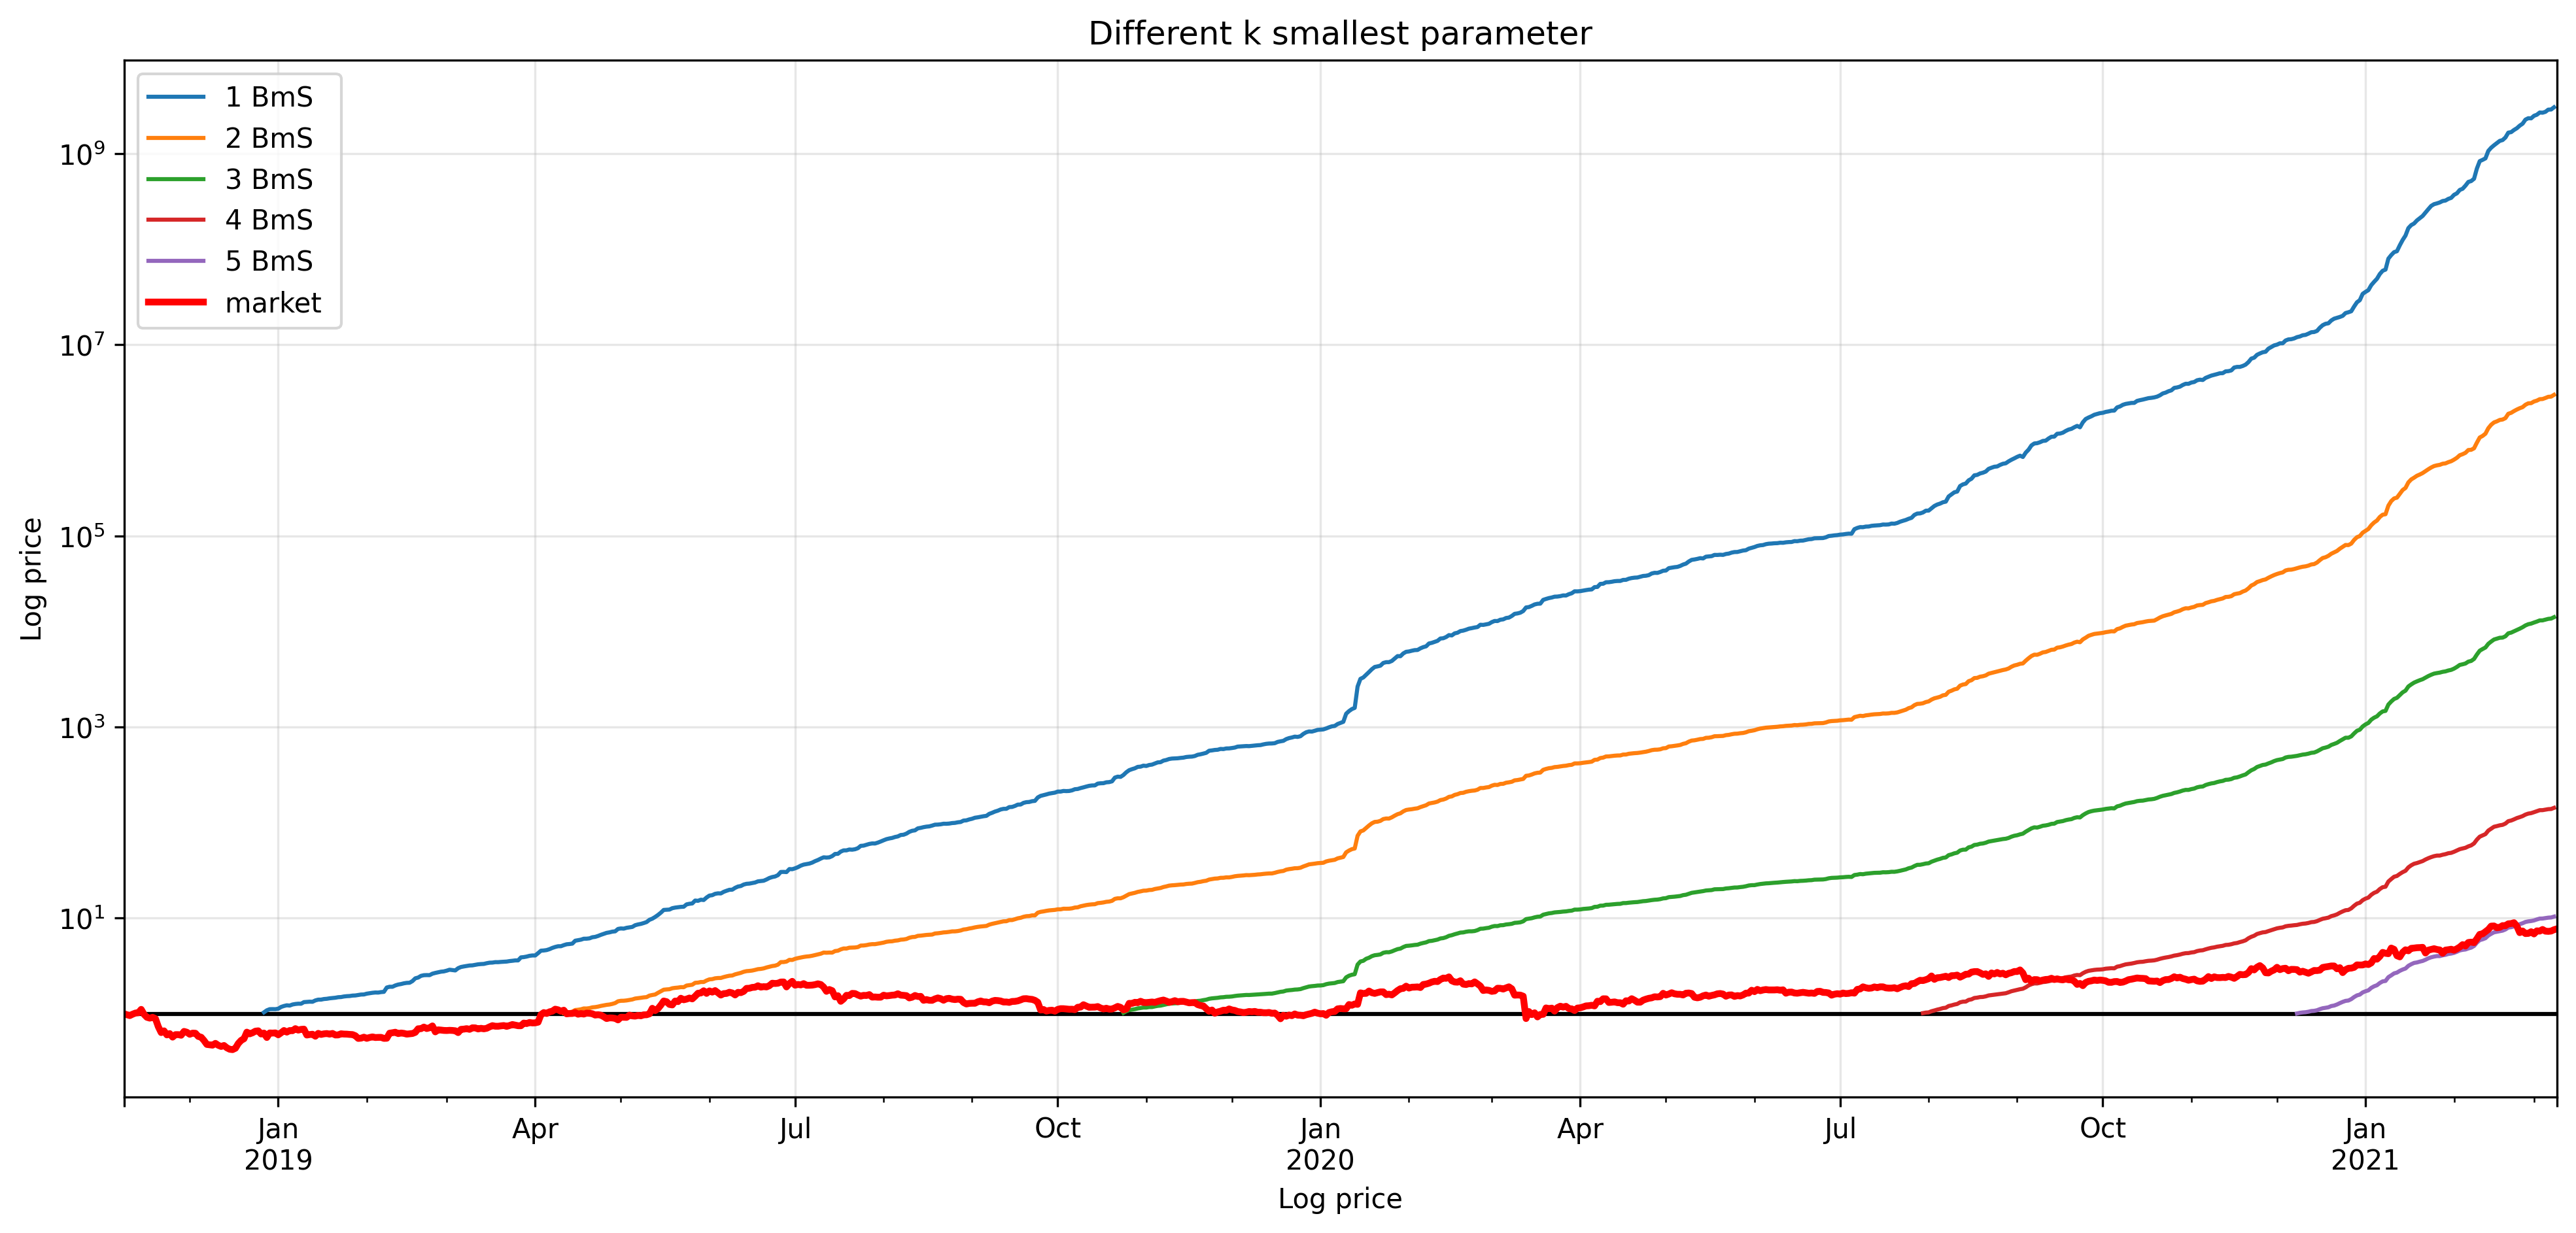

In [667]:
all_returns = pd.DataFrame()
all_positions = pd.DataFrame()

all_carry = pivot(futures_huobi[futures_huobi['length'] == 'week'])
all_price =  pivot(spot, 'price').loc[all_carry.index, all_carry.columns]

for kbest in tqdm(range(1, 6)):
    
    positions = pd.DataFrame(np.nan, columns=all_carry.columns, index=all_carry.index)
    
    for date, carry in all_carry.iterrows():
        
        if len(carry.dropna()) > 2 * kbest:
            best = carry.nlargest(kbest).index
            worst = carry.nsmallest(kbest).index

            positions.loc[date, best] = 1
            positions.loc[date, worst] = -1        
    
    returns = (1 + (positions * all_price.pct_change().shift(-1)).mean(axis=1))
    returns.name = f'{kbest} BmS'
    all_returns = all_returns.append(returns.T)
    all_positions = all_positions.append(positions)

    
f, ax = plt.subplots(figsize=(16, 7), dpi=300)

pd.DataFrame(all_returns).T.cumprod().plot(ax=ax, label=f'')
(1 + all_price.pct_change().mean(axis=1)).cumprod().plot(ax=ax, c='red', label='market ', lw=2.5)
ax.hlines(1, xmin=positions.index[0], xmax=positions.index[-1])
plt.grid(alpha=0.3)
ax.legend()

ax.set_title('Different k smallest parameter')
ax.set_ylabel('Log price')
ax.set_xlabel('Log price')

ax.set_yscale('log')

plt.savefig('loosers.png')


print('general stats')
for i in range(1, 5):
    returns = all_returns.T.iloc[:, -i].dropna() - 1
    res = PerformanceStats(returns=returns, risk_free=risk_free.loc[returns.index, :]['risk_free'], symbol='')
    print(i, f"|winrate: {round(res.winning_trades, 3)} | sharpe:{round(res.sharpe, 3)} | avg r per trade: {round(res.average_return_per_trade, 3)}")
    
print('\nalpha, beta')
for i in range(1, 5):
    returns = all_returns.T.iloc[:, -i].dropna() - 1
    market_return = ccmix_index.loc[returns.index]['CCMIX'].pct_change().fillna(0)
    risk_free_ = risk_free['risk_free'].loc[market_return.index]
    excess_return = market_return - risk_free_
    excess_return.name = 'excess'


    results = MeanTest(returns=returns - risk_free.loc[returns.index]['risk_free'] / 100,
             index=excess_return) 

    print(i, f' | alpha: {round(results.mean_estimation, 3)} p: {round(results.mean_p_value, 3)}| beta: {round(results.independent_estimation, 3)} p: {round(results.independent_p_value, 3)}|')
    
print('\nalpha, beta, dd')

for i in range(1, 5):
    returns = all_returns.T.iloc[:, -i].dropna() - 1
    market_return = ccmix_index.loc[returns.index][['return', 'dummy']]
    market_return['return'] = market_return['return'] - risk_free_

    results = DMBeta(returns=returns - risk_free.loc[returns.index]['risk_free'] / 100, market=market_return)

    print(i, f' | alpha: {round(results.alpha, 3)}, p {round(results.alpha_p, 4)} | beta: {round(results.beta, 3)}, p {round(results.alpha_p, 4)} | upside: {round(results.upside_market_beta, 3)} p {round(results.upside_market_beta_p, 3)}')
    
    
    
    
    

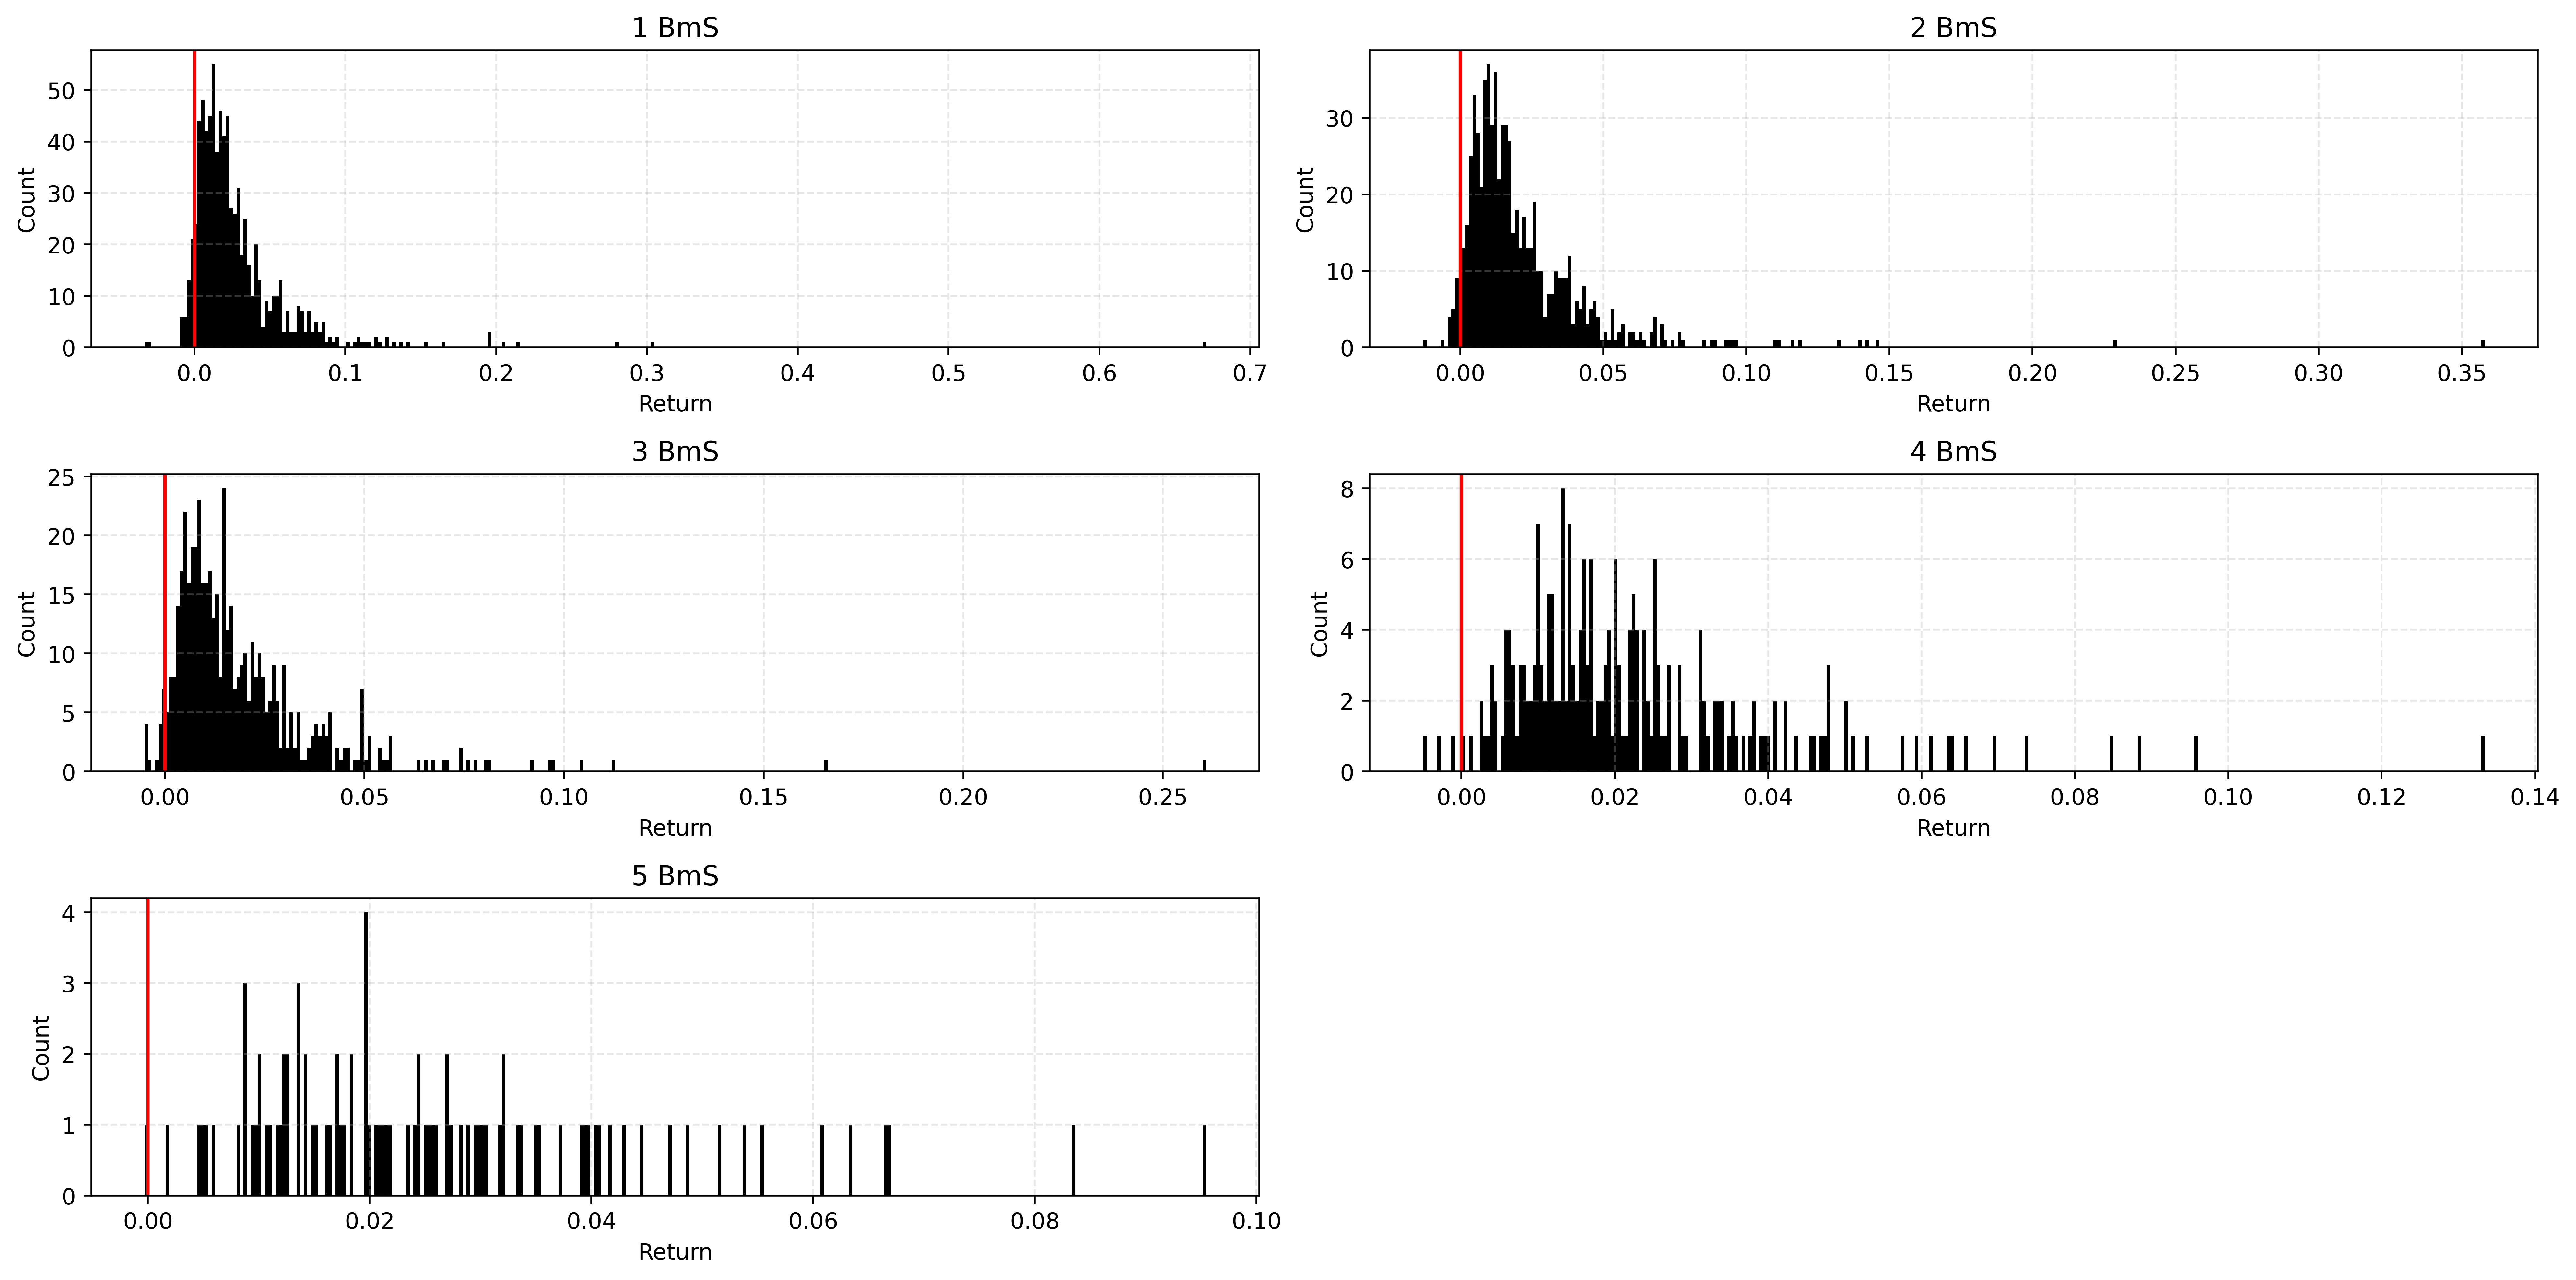

In [669]:
f, ax = plt.subplots(figsize=(16, 8), dpi=500)



ax = (all_returns.T - 1).hist(bins=300, ax=ax, color='black', grid=False)
ax[0][0].grid(alpha=0.3, ls='--')
ax[0][0].set_xlabel('Return')
ax[0][0].axvline(0, color='red')
ax[0][0].set_ylabel('Count')


ax[0][1].set_xlabel('Return')
ax[0][1].grid(alpha=0.3, ls='--')
ax[0][1].set_ylabel('Count')
ax[0][1].axvline(0, color='red')

ax[1][0].grid(alpha=0.3, ls='--')
ax[1][0].axvline(0, color='red')
ax[1][0].set_xlabel('Return')
ax[1][0].set_ylabel('Count')


ax[1][1].grid(alpha=0.3, ls='--')
ax[1][1].axvline(0, color='red')
ax[1][1].set_xlabel('Return')
ax[1][1].set_ylabel('Count')


ax[2][0].grid(alpha=0.3, ls='--')
ax[2][0].axvline(0, color='red')
ax[2][0].set_xlabel('Return')
ax[2][0].set_ylabel('Count')


plt.tight_layout()
plt.savefig('imgs/carry_sim_2quarter.png')

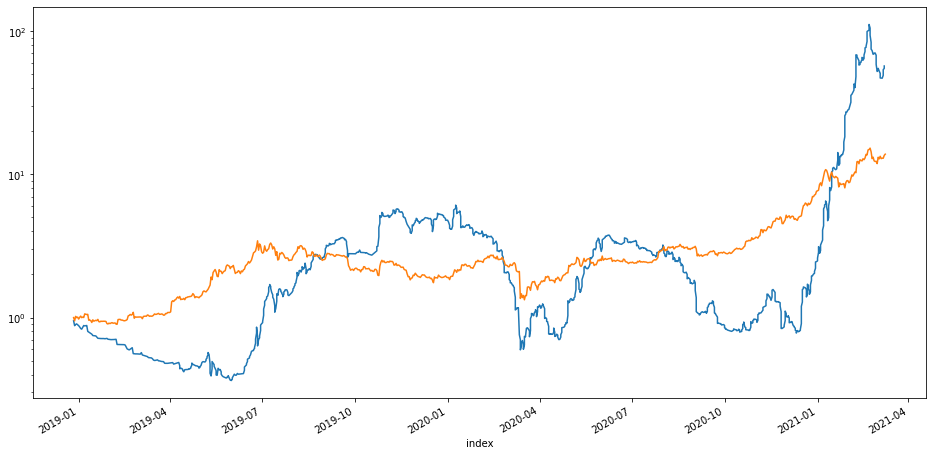

In [511]:
f, ax = plt.subplots(figsize=(16, 8))

symbol = 'BTC'

cumulated = (1 + (all_positions[symbol] * all_price[symbol].pct_change().shift(-1)).dropna()).cumprod()
start_date = cumulated.sort_index().index[0]
cumulated.plot(ax=ax)
ax.set_yscale('log')

(all_price[symbol].loc[start_date:] / all_price[symbol].loc[start_date]).plot(ax=ax)

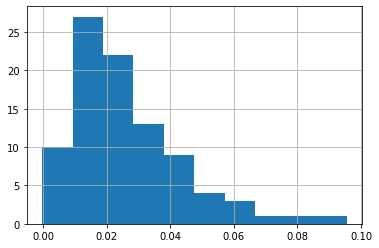

In [513]:
(positions * all_price.pct_change().shift(-1)).mean(axis=1).hist()

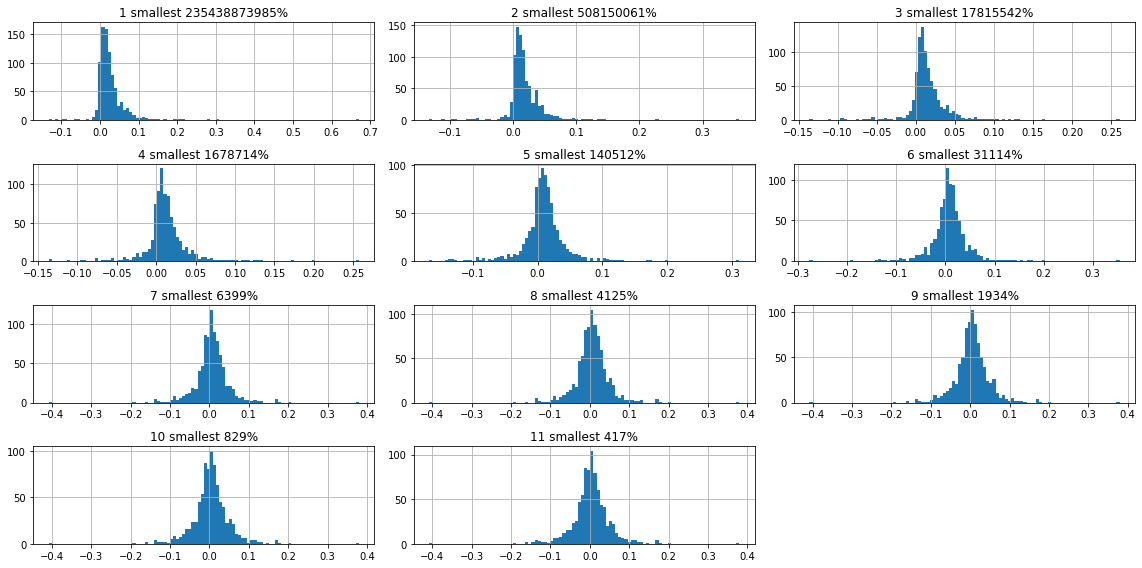

In [360]:
(all_returns.T - 1).hist(bins=100, figsize=(16, 8))
plt.tight_layout()

### Winners

  0%|          | 0/11 [00:00<?, ?it/s]

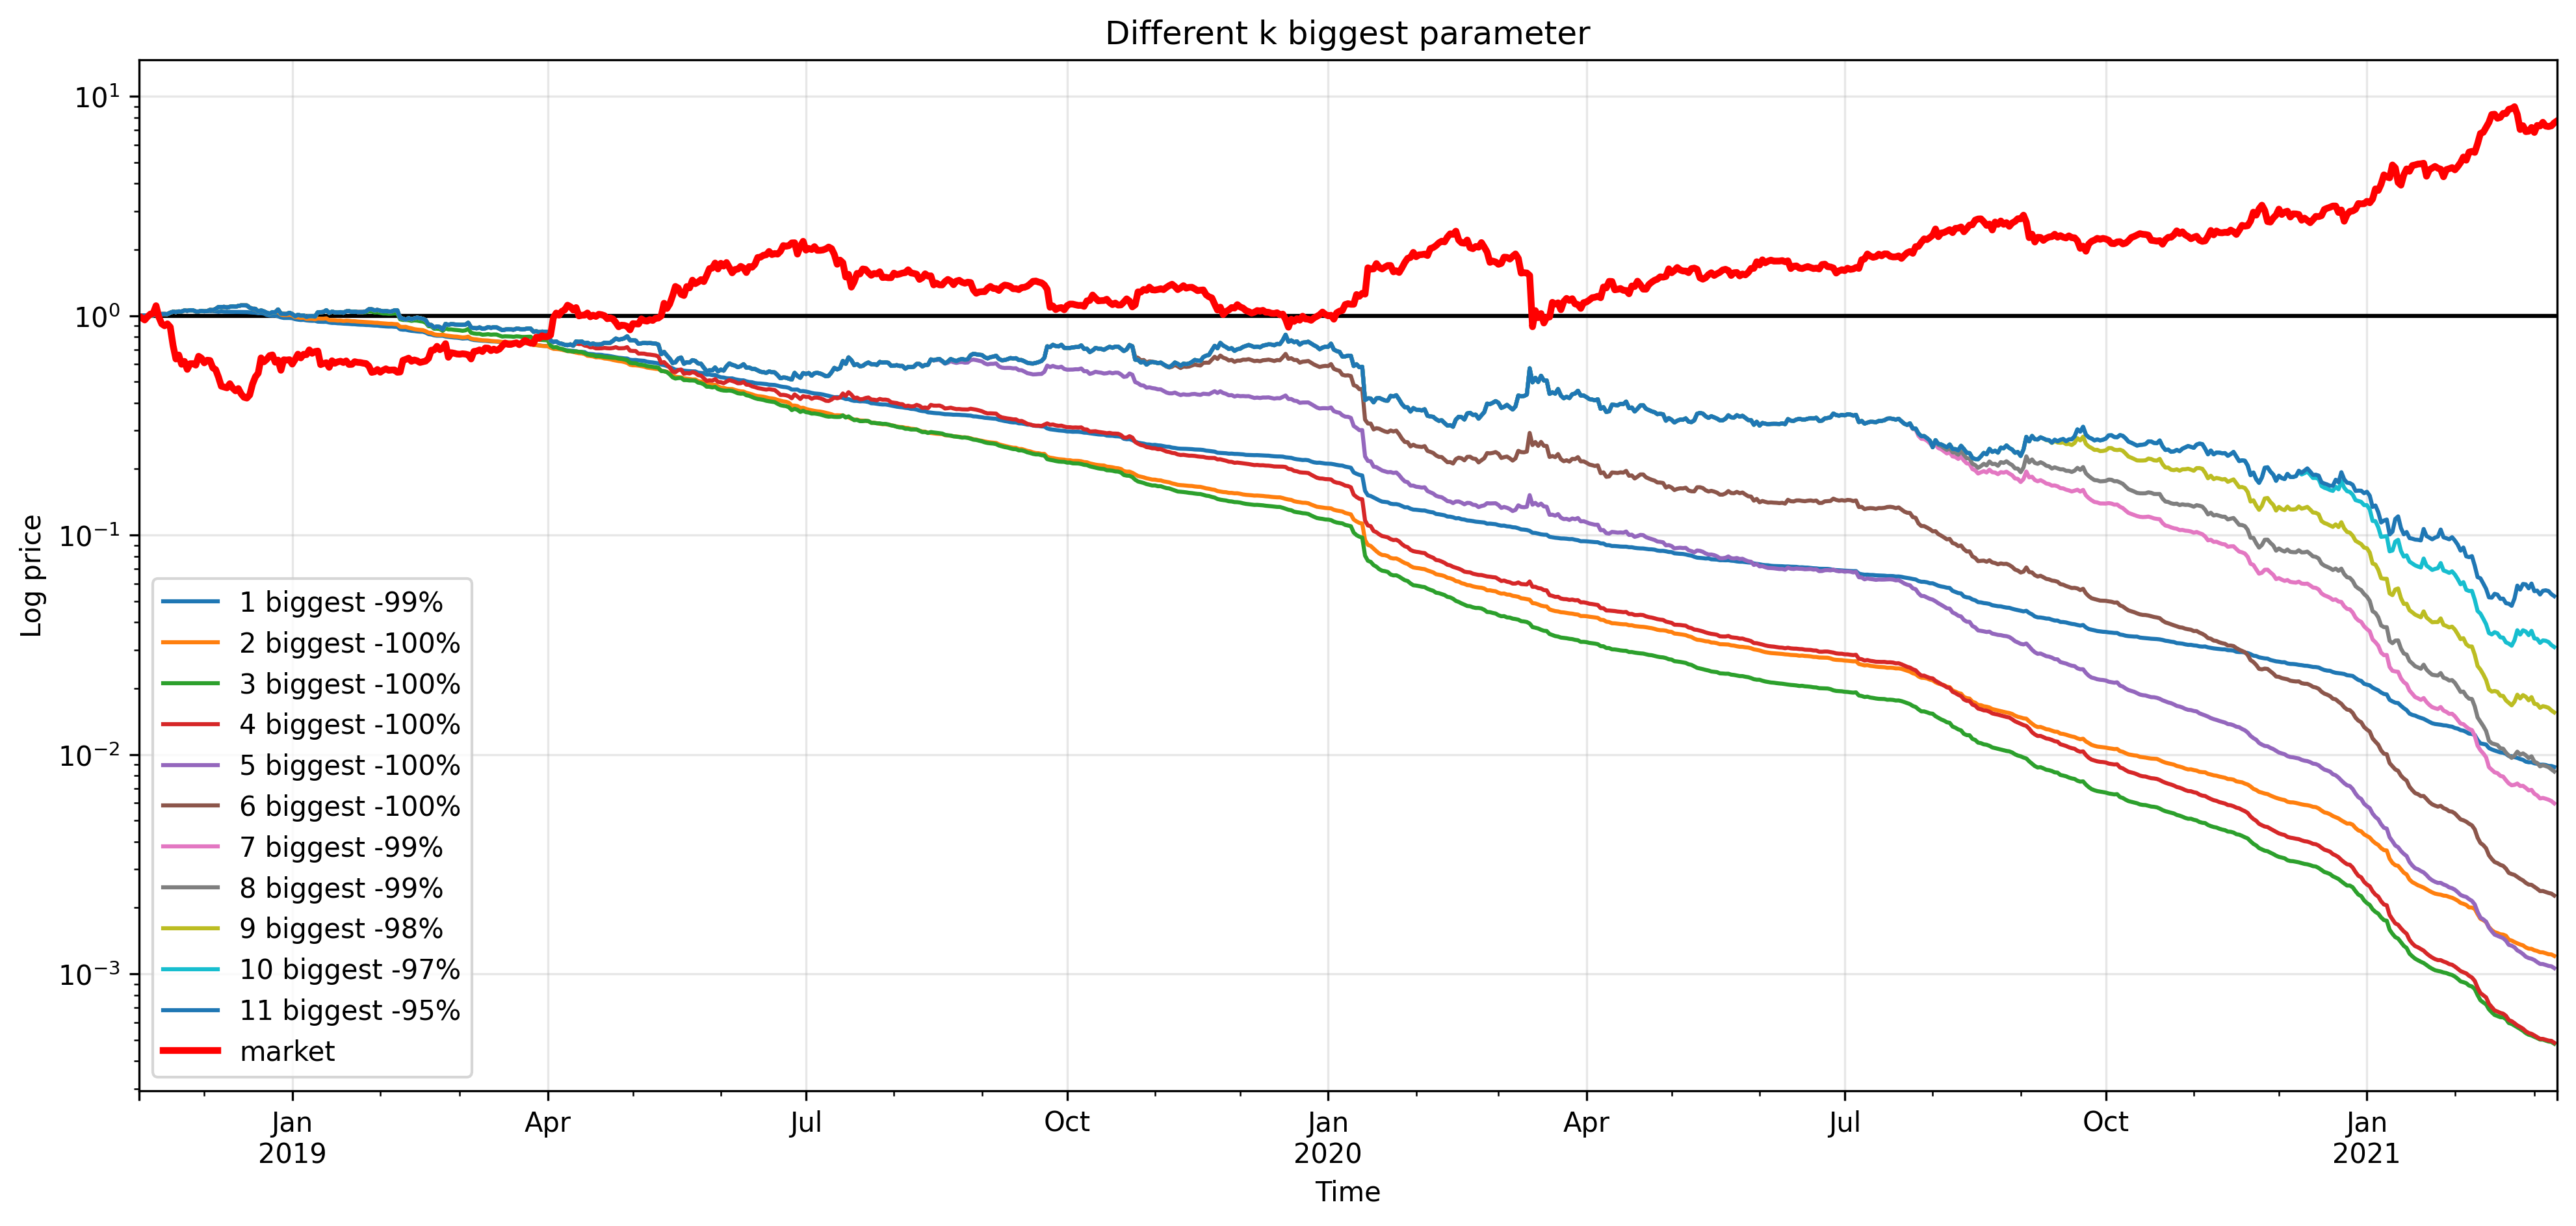

In [43]:
all_returns = pd.DataFrame()
all_carry = pivot(futures_huobi[futures_huobi['length'] == 'week'])
all_price =  pivot(spot, 'price').loc[all_carry.index, all_carry.columns]


for kbest in tqdm(range(1, 12)):
    
    positions = pd.DataFrame(columns=all_carry.columns, index=all_carry.index).fillna(0)
    
    for date, carry in all_carry.iterrows():
        
        best = carry.nlargest(kbest).index
        worst = carry.nsmallest(kbest).index
        
        positions.loc[date, best] = 1
        positions.loc[date, worst] = -1
    
    returns = (1 + (positions * all_price.pct_change().shift(-1)).mean(axis=1))
    returns.name = f'{kbest} biggest {round((returns.prod() - 1) * 100)}%'
    all_returns = all_returns.append(returns.T)

f, ax = plt.subplots(figsize=(16, 7), dpi=300)

pd.DataFrame(all_returns).T.cumprod().plot(ax=ax)
(1 + all_price.pct_change().mean(axis=1)).cumprod().plot(ax=ax, c='red', label='market', lw=2.5)
ax.hlines(1, xmin=positions.index[0], xmax=positions.index[-1])
plt.grid(alpha=0.3)

ax.set_title('Different k biggest parameter')
ax.set_ylabel('Log price')
ax.set_xlabel('Time')

ax.legend()
ax.set_yscale('log')

plt.savefig('winners.png')

### Loosers diff types

  0%|          | 0/3 [00:00<?, ?it/s]

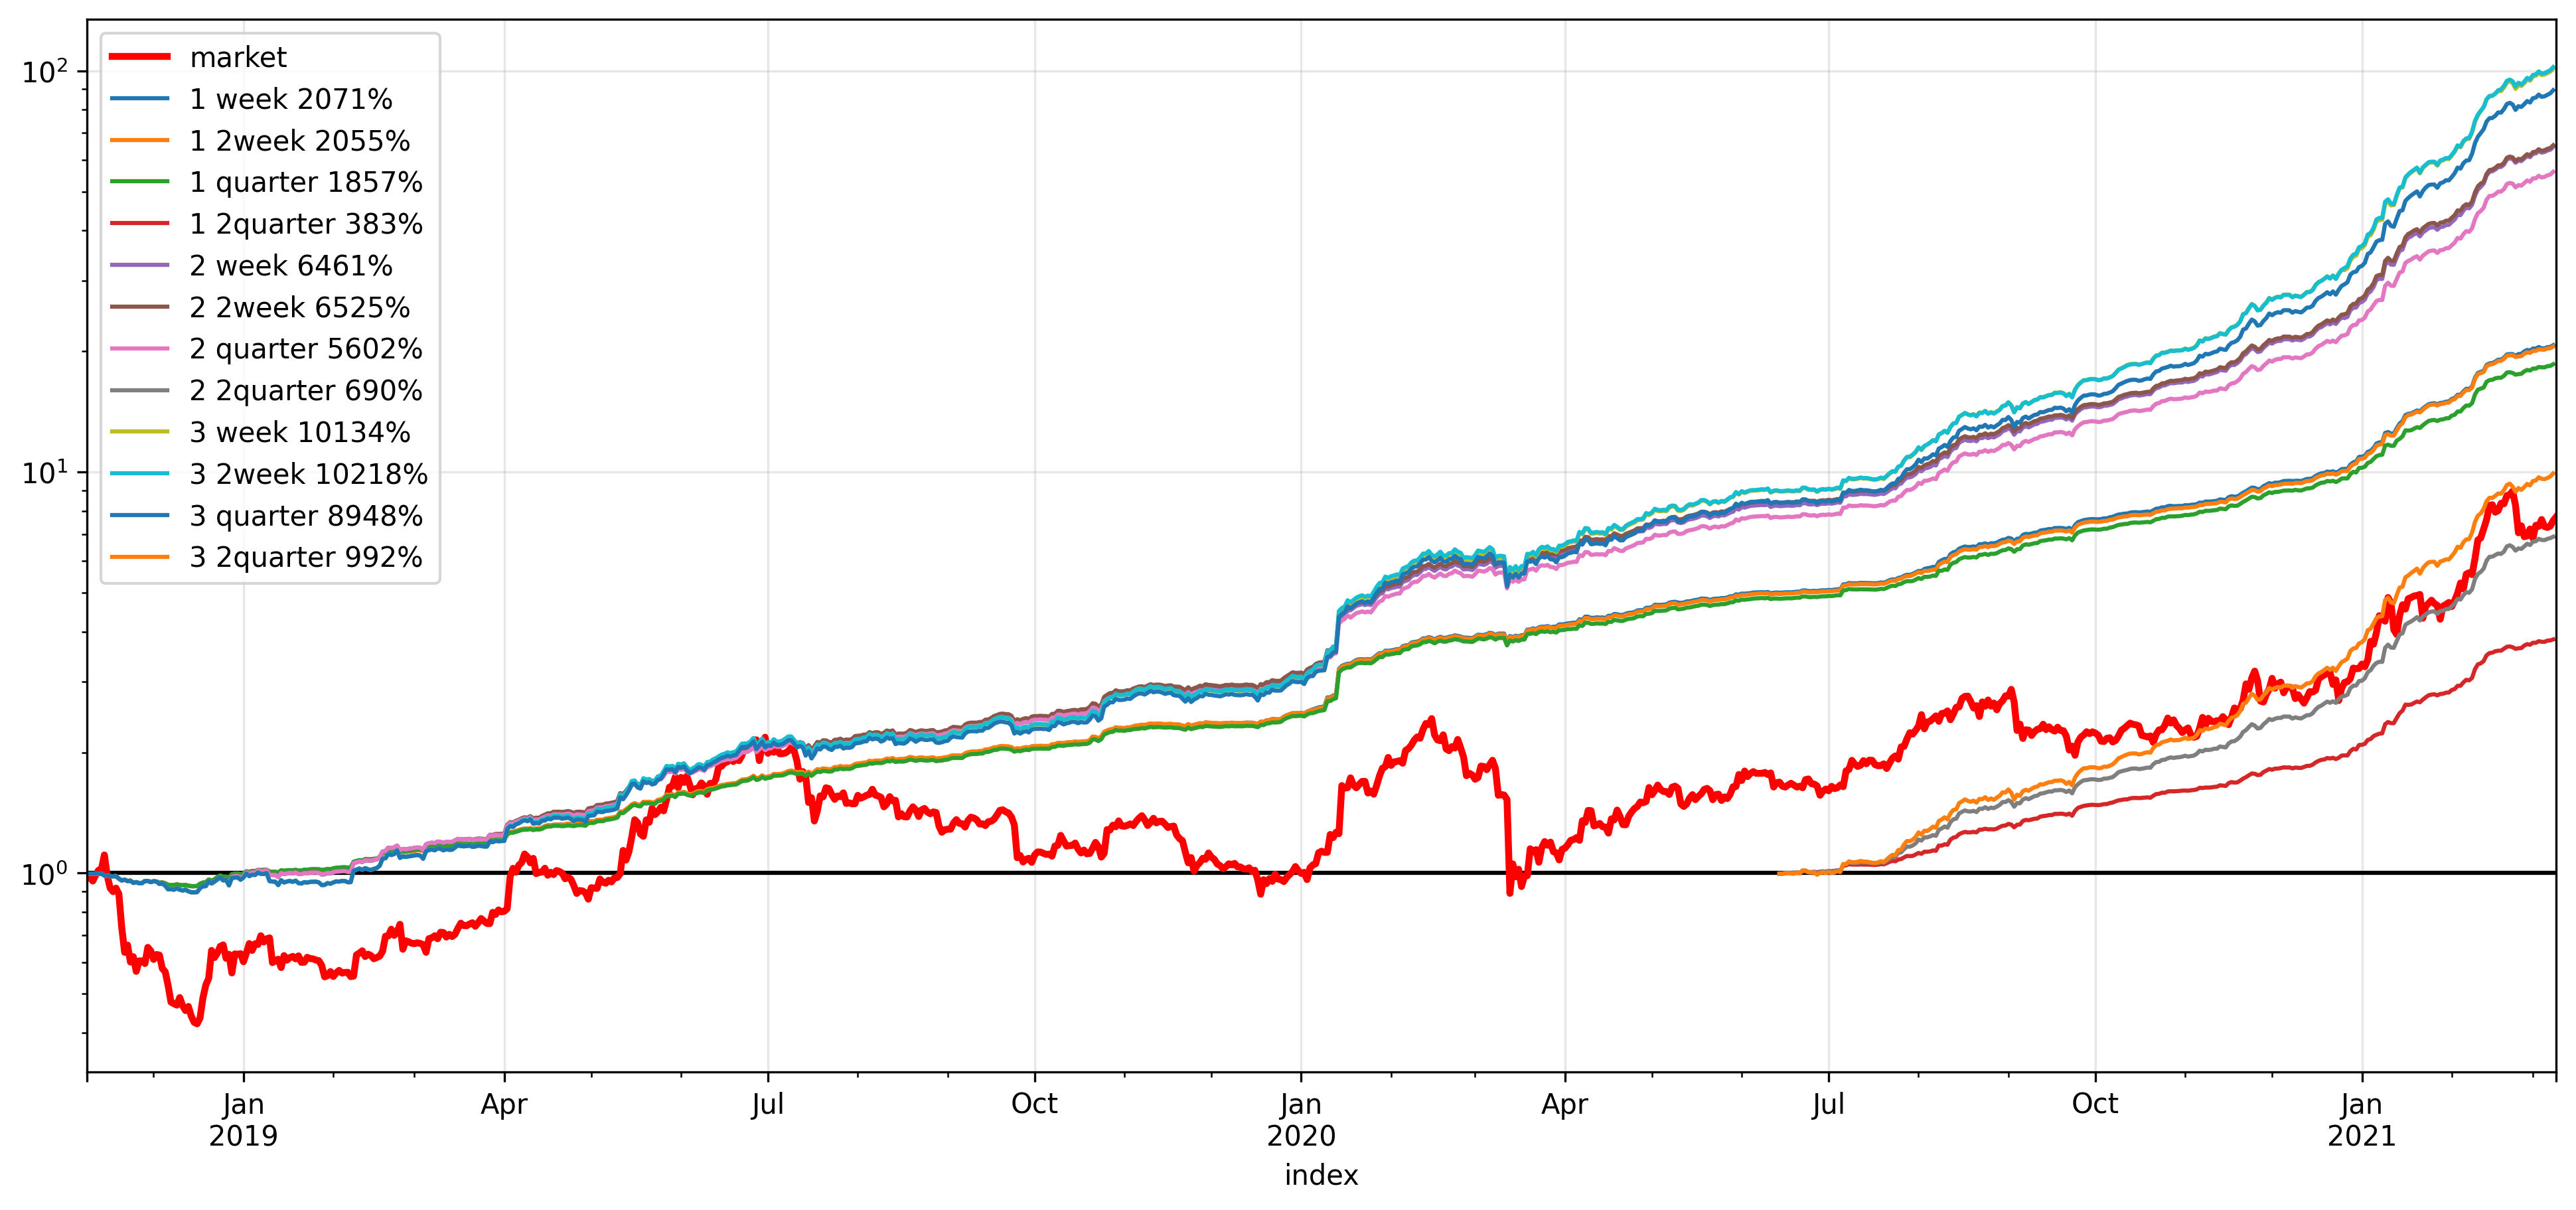

In [384]:
all_returns = pd.DataFrame()
for kbest in tqdm(range(1, 4)):
    for type_ in ['week', '2week', 'quarter', '2quarter']:
        
        all_carry = pivot(futures_huobi[futures_huobi['length'] == type_])
        all_price =  pivot(spot, 'price').loc[all_carry.index, all_carry.columns]
        positions = pd.DataFrame(columns=all_carry.columns, index=all_carry.index).fillna(0)

        for date, carry in all_carry.iterrows():
            
            best = carry.nsmallest(kbest).index
            worst = carry.nsmallest(kbest).index

            positions.loc[date, best] = 1
            positions.loc[date, worst] = -1

        returns = (1 + (positions * all_price.pct_change().shift(-1)).mean(axis=1))
        returns.name = f'{kbest} {type_} {round(returns.prod() * 100)}%'
        all_returns = all_returns.append(returns.T)
        
all_carry = pivot(futures_huobi[futures_huobi['length'] == 'week'])
all_price =  pivot(spot, 'price').loc[all_carry.index, all_carry.columns]

f, ax = plt.subplots(figsize=(16, 7), dpi=300)

start_date, end_date = pivot(futures_huobi[futures_huobi['length'] == 'week']).index[0], pivot(futures_huobi[futures_huobi['length'] == 'week']).index[-1]

(1 + all_price.pct_change().mean(axis=1)).cumprod().plot(ax=ax, c='red', label='market', lw=2.5)

pd.DataFrame(all_returns).T.cumprod().plot(ax=ax, label=f'')
ax.hlines(1, xmin=start_date, xmax=end_date)
plt.grid(alpha=0.3)
ax.legend()
ax.set_yscale('log')

plt.savefig('loosers_diff.png')


### Different rebalancing periods

In [75]:
all_carry = pivot(futures_huobi[futures_huobi['length'] == '2quarter'])
all_price =  pivot(spot, 'price').loc[all_carry.index, all_carry.columns]

  0%|          | 0/11 [00:00<?, ?it/s]

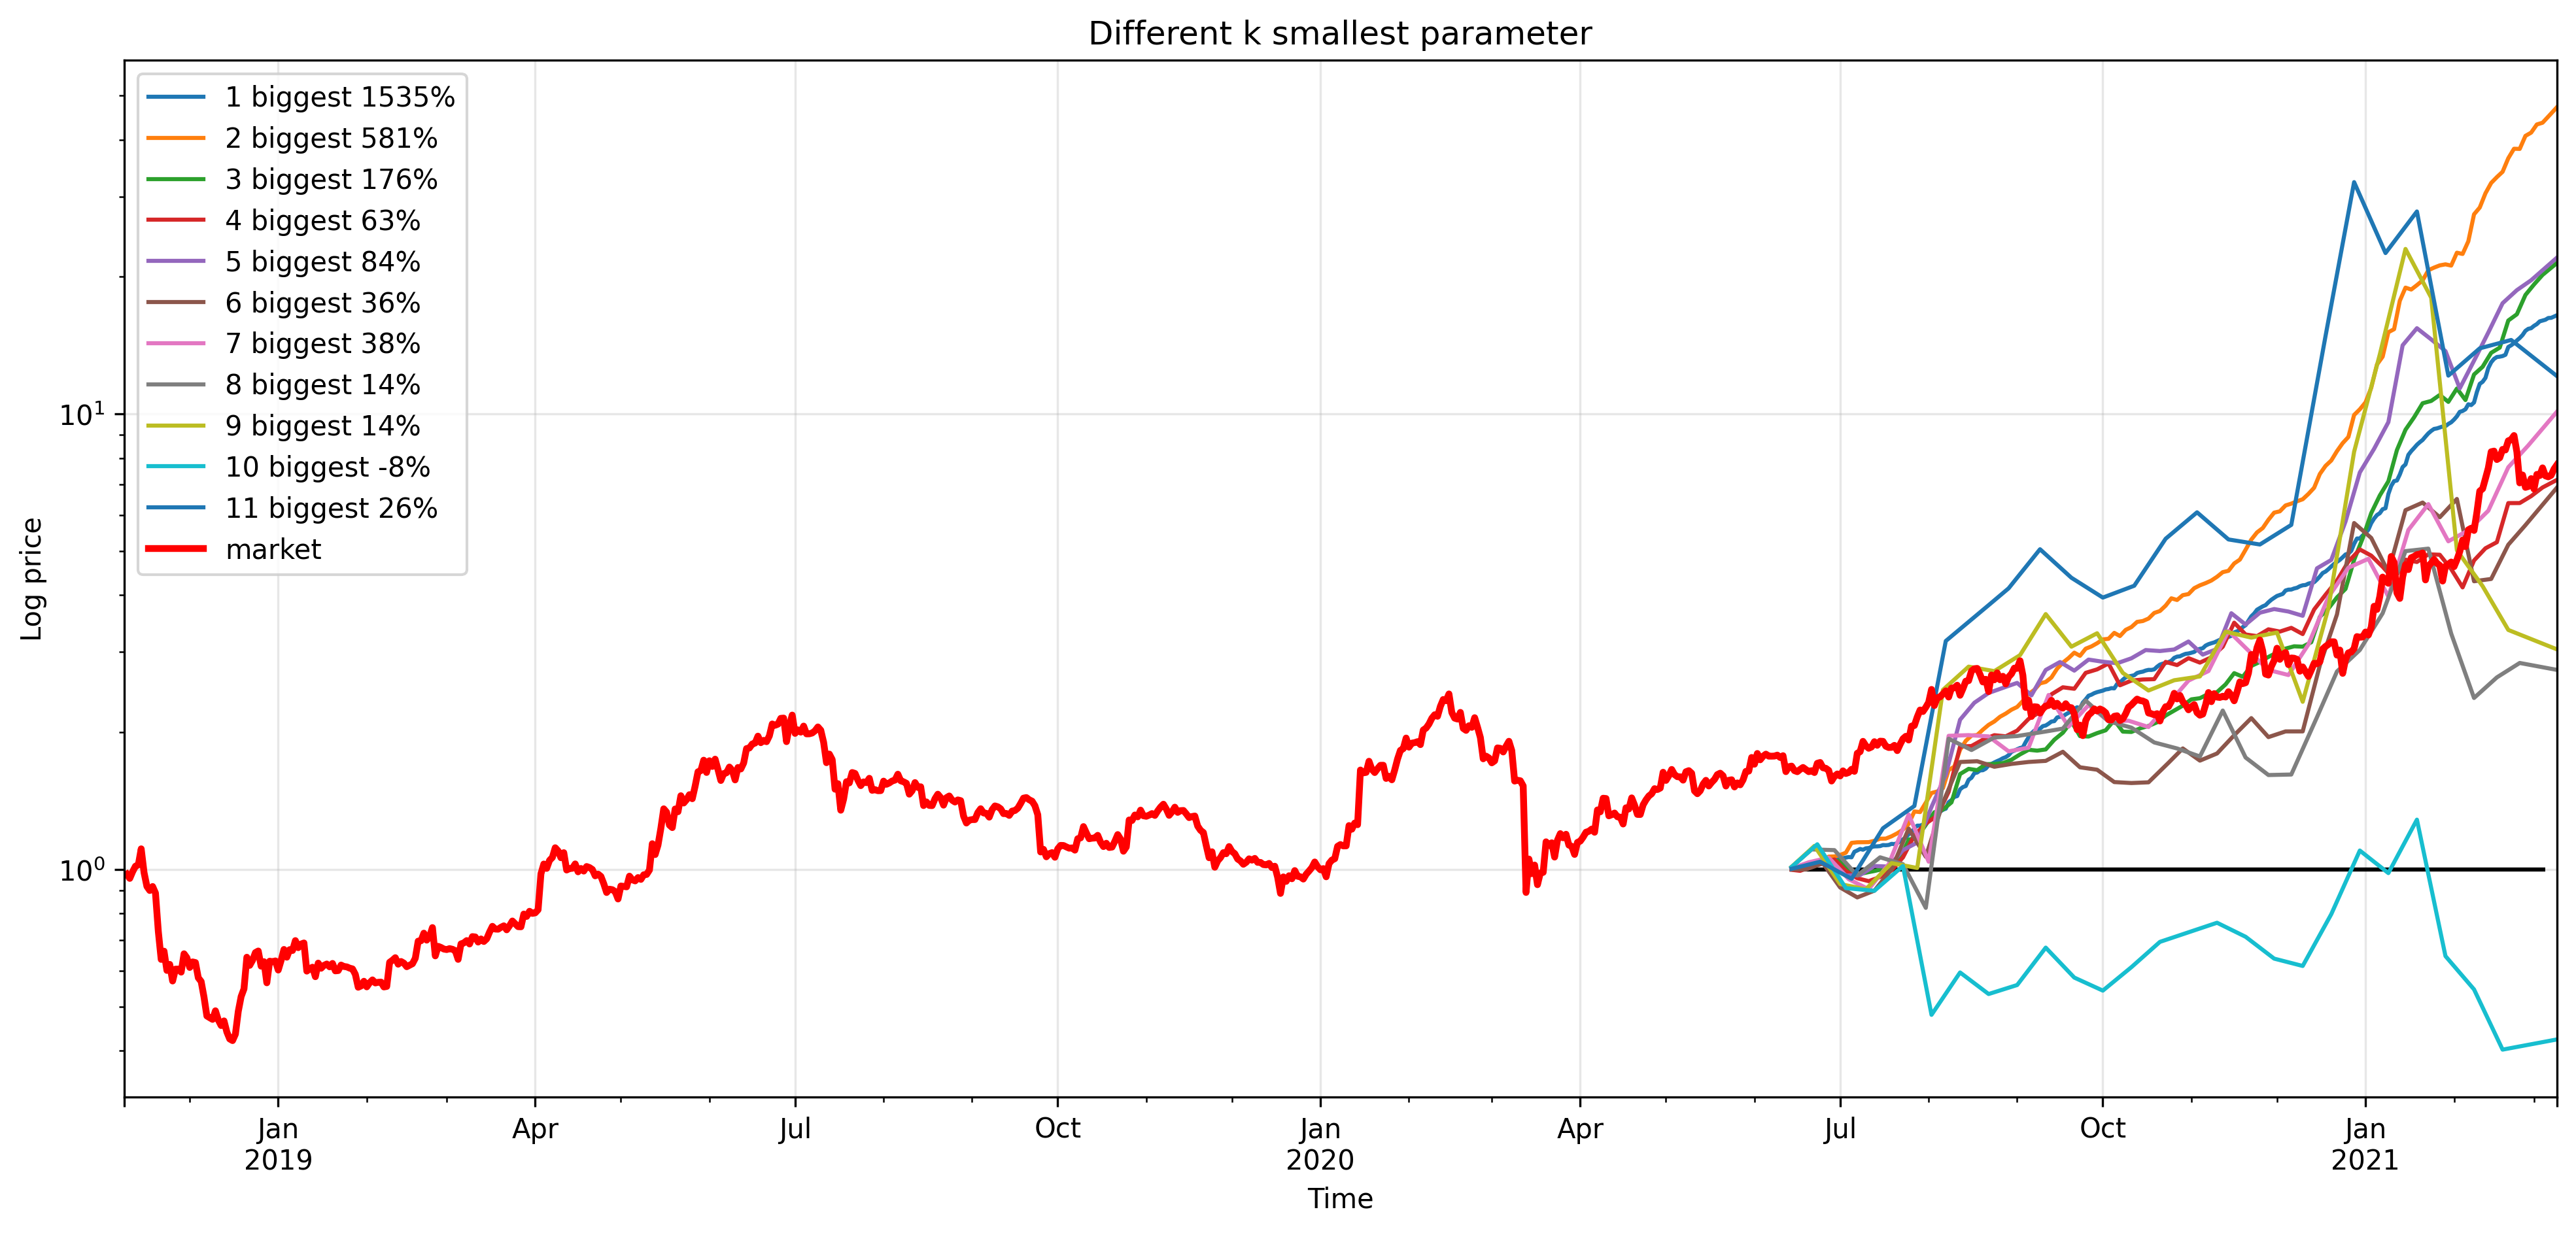

In [76]:

all_returns = pd.DataFrame()
for week_count in tqdm(range(1, 12)):

    all_carry_ = all_carry.resample(f'{week_count}d').mean()
    all_price_ = all_price.resample(f'{week_count}d').last()
    
    positions = pd.DataFrame(columns=all_carry_.columns, index=all_carry_.index).fillna(0)
    
    for date, carry in all_carry_.iterrows():
        best = carry.nsmallest(2).index
        worst = carry.nlargest(2).index
        
        positions.loc[date, best] = 1
        positions.loc[date, worst] = -1
        
        returns = (1 + (positions * all_price_.pct_change().shift(-1)).mean(axis=1))
        
    returns.name = f'{week_count} biggest {round((returns.prod() - 1) * 100)}%'
    all_returns = all_returns.append(returns.T)
    
f, ax = plt.subplots(figsize=(16, 7), dpi=300)

pd.DataFrame(all_returns).T.fillna(method='ffill').cumprod().resample('1d').fillna(method='ffill').plot(ax=ax)
market_price.plot(ax=ax, c='red', label='market', lw=2.5)
ax.hlines(1, xmin=positions.index[0], xmax=positions.index[-1])
plt.grid(alpha=0.3)

ax.set_title('Different k smallest parameter')
ax.set_ylabel('Log price')
ax.set_xlabel('Time')

ax.legend()
ax.set_yscale('log')

plt.savefig('loosers_diff_rebalance.png')

  0%|          | 0/11 [00:00<?, ?it/s]

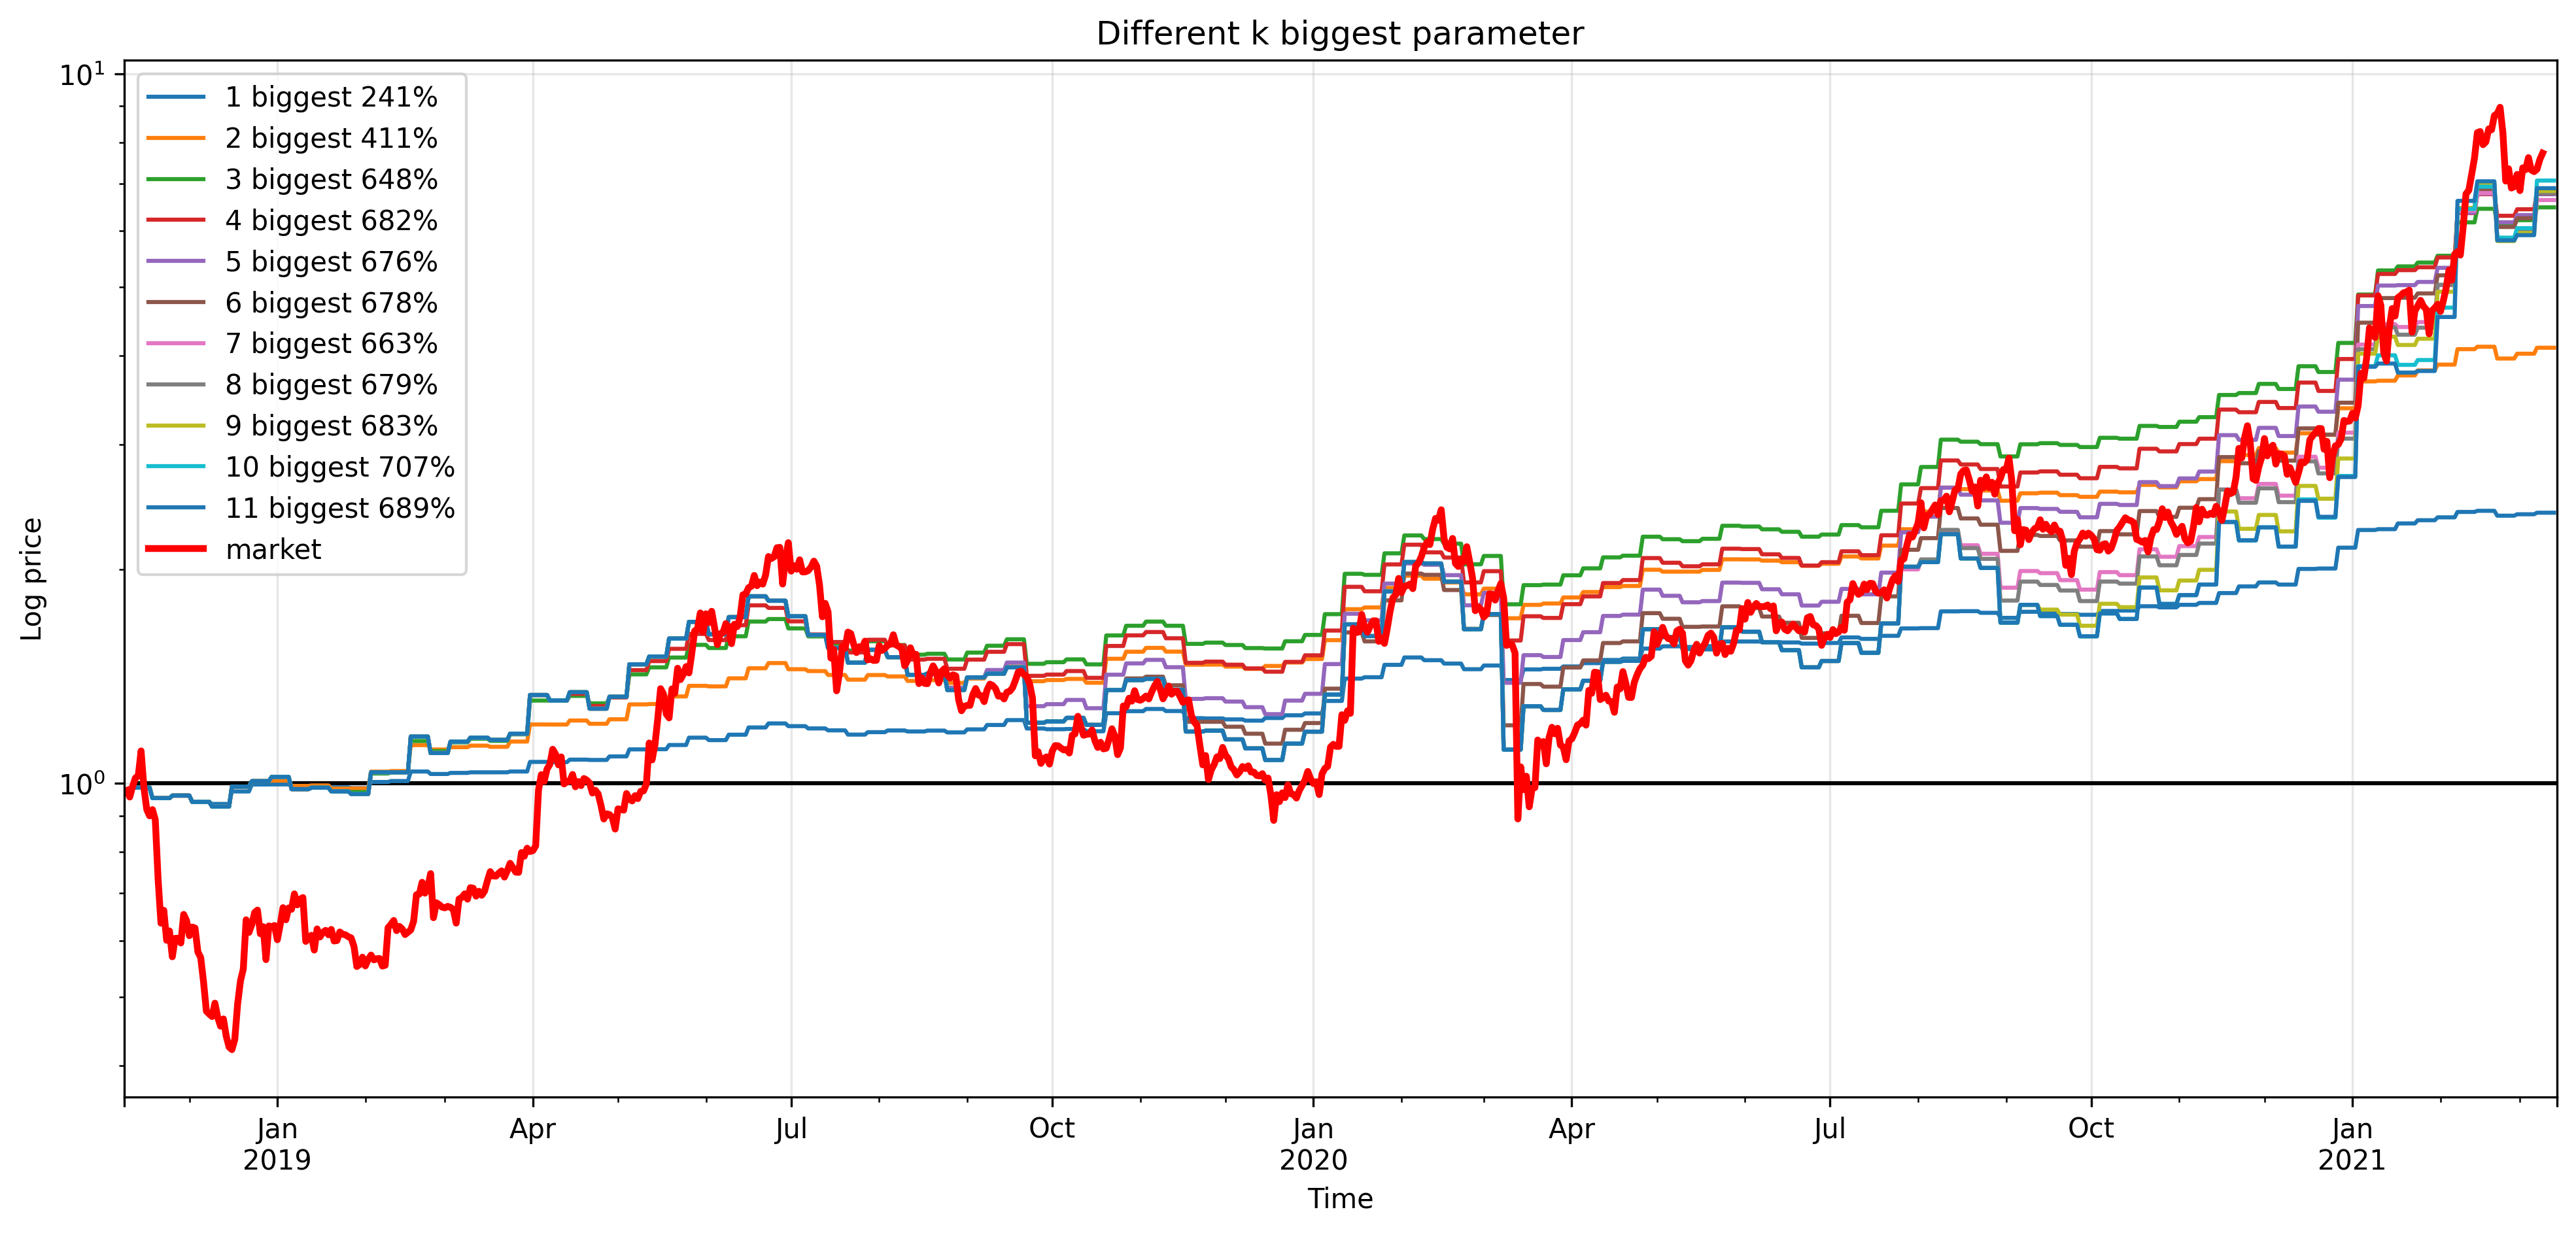

In [272]:
all_carry = pivot(futures_huobi[futures_huobi['length'] == 'week'])
all_price =  pivot(spot, 'price').loc[all_carry.index, all_carry.columns]

positions = pd.DataFrame(columns=all_carry.columns, index=all_carry.index).fillna(0)

all_carry = pivot(futures_huobi[futures_huobi['length'] == '2week']).resample('1w').last()
all_price =  pivot(spot, 'price').loc[all_carry.index, all_carry.columns]
positions = pd.DataFrame(columns=all_carry.columns, index=all_carry.index).fillna(0)

all_returns = pd.DataFrame()
for kbest in tqdm(range(1, 12)):
    
    positions = pd.DataFrame(columns=all_carry.columns, index=all_carry.index).fillna(0)
    
    for date, carry in all_carry.iterrows():
        best = carry.nsmallest(kbest).index
        
        positions.loc[date, best] = 1
        returns = (1 + (positions * all_price.pct_change().shift(-1)).mean(axis=1))
        
    returns.name = f'{kbest} biggest {round(returns.prod() * 100)}%'
    all_returns = all_returns.append(returns.T)
    
f, ax = plt.subplots(figsize=(16, 7), dpi=300)

pd.DataFrame(all_returns).T.cumprod().resample('1d').fillna('ffill').plot(ax=ax)
market_price.plot(ax=ax, c='red', label='market', lw=2.5)
ax.hlines(1, xmin=positions.index[0], xmax=positions.index[-1])
plt.grid(alpha=0.3)

ax.set_title('Different k biggest parameter')
ax.set_ylabel('Log price')
ax.set_xlabel('Time')

ax.legend()
ax.set_yscale('log')

### Best portfel testing

0it [00:00, ?it/s]

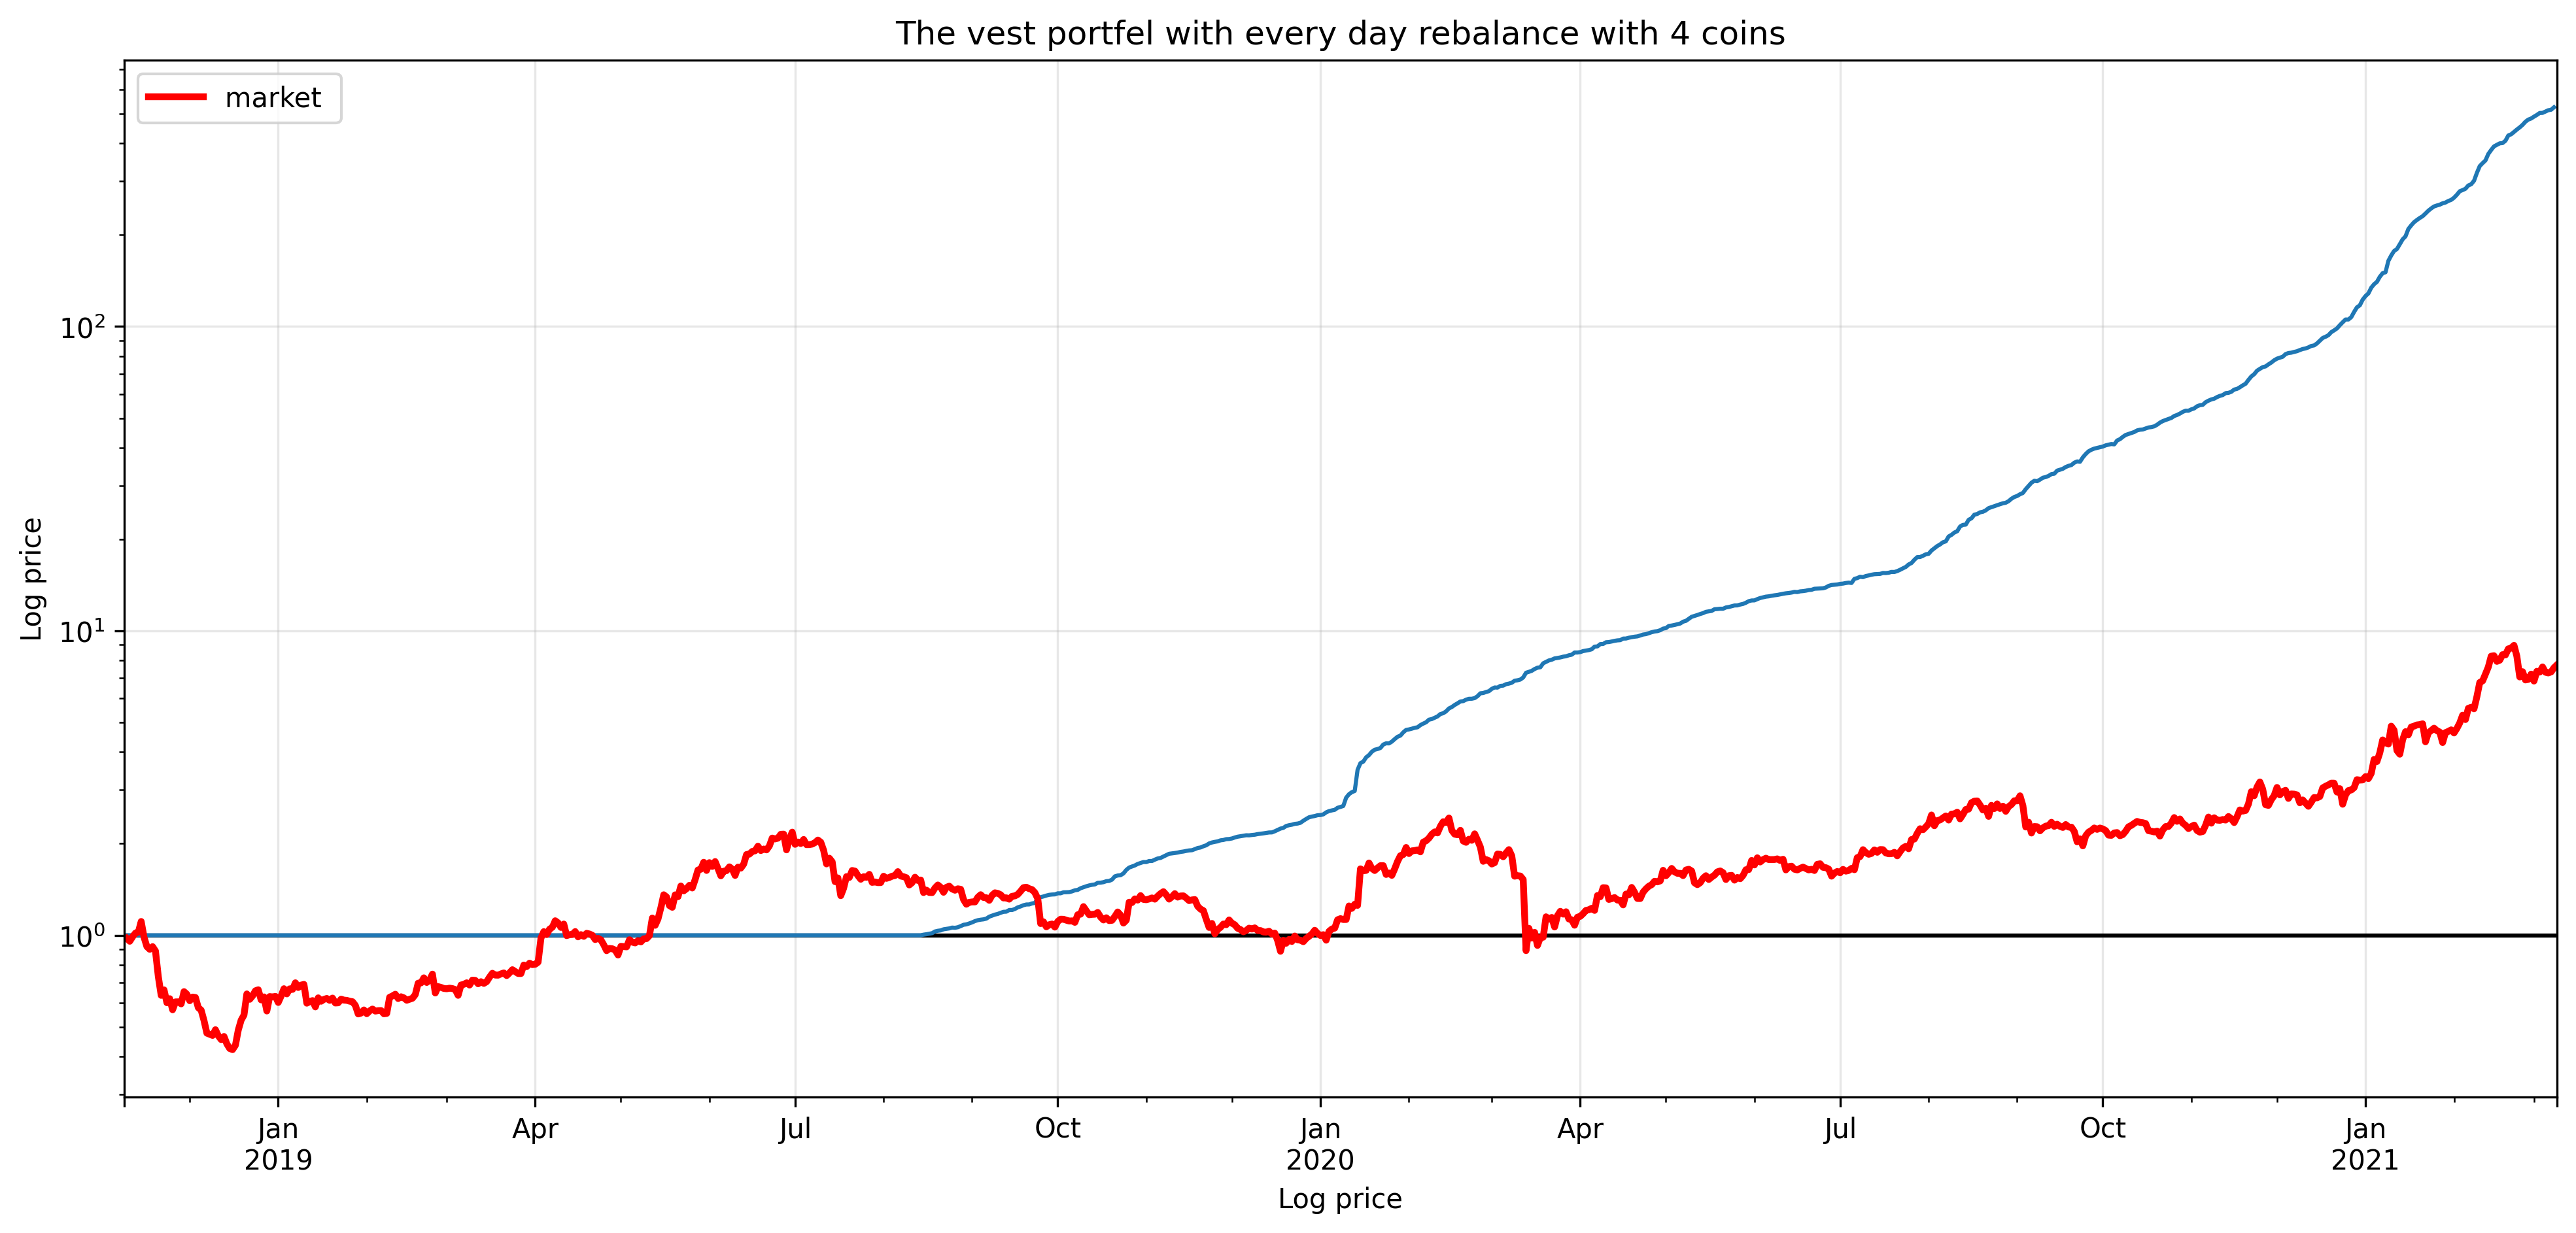

In [589]:
all_returns = pd.DataFrame()
all_carry = pivot(futures_huobi[futures_huobi['length'] == 'week'])
all_price =  pivot(spot, 'price').loc[all_carry.index, all_carry.columns]

    
positions = pd.DataFrame(columns=all_carry.columns, index=all_carry.index).fillna(0)
    
for date, carry in tqdm(all_carry.iterrows()):
    if len(carry.dropna()) >= 2 * 3:
    
        best = carry.nsmallest(3).index
        worst = carry.nlargest(3).index

        positions.loc[date, best] = 1
        positions.loc[date, worst] = -1
    
    
returns = (1 + (positions * all_price.pct_change().shift(-1)).mean(axis=1))
returns.name = f'{4} smallest {round(returns.prod() * 100)}%'

    
f, ax = plt.subplots(figsize=(16, 7), dpi=300)

returns.cumprod().plot(ax=ax, label=f'')
(1 + all_price.pct_change().mean(axis=1)).cumprod().plot(ax=ax, c='red', label='market ', lw=2.5)
ax.hlines(1, xmin=positions.index[0], xmax=positions.index[-1])
plt.grid(alpha=0.3)
ax.legend()

ax.set_title('The vest portfel with every day rebalance with 4 coins')
ax.set_ylabel('Log price')
ax.set_xlabel('Log price')

ax.set_yscale('log')
returns = (returns - 1).dropna()

plt.savefig('best_portfolio.png')

In [598]:
cumulated_

coin               ADA          BCH           BSV       BTC        DOT  \
index                                                                    
2018-11-08    1.000000     1.000000           NaN  1.000000        NaN   
2018-11-09    1.000000     1.000000           NaN  1.000000        NaN   
2018-11-10    1.000000     1.000000      1.000000  1.000000        NaN   
2018-11-11    1.000000     1.000000      1.000000  1.000000        NaN   
2018-11-12    1.000000     1.000000      1.000000  1.000000        NaN   
...                ...          ...           ...       ...        ...   
2021-03-05  142.721180  5274.831897  22955.694826  2.391522  46.974752   
2021-03-06  146.614734  5274.831897  22955.694826  2.391522  46.653073   
2021-03-07  146.119351  5274.831897  22369.831878  2.503426  46.653073   
2021-03-08  147.852532  5274.831897  22329.055342  2.552967  46.653073   
2021-03-09         NaN          NaN           NaN       NaN        NaN   

coin              EOS         ETC         ETH       FIL        LINK  \
index                                                                 
2018-11-08    1.00000    1.000000    1.000000       NaN    1.000000   
2018-11-09    1.00000    1.000000    1.000000       NaN    1.000000   
2018-11-10    1.00000    1.000000    1.000000       NaN    1.000000   
2018-11-11    1.00000    1.000000    1.000000       NaN    1.000000   
2018-11-12    1.00000    1.000000    1.000000       NaN    1.000000   
...               ...         ...         ...       ...         ...   
2021-03-05  147.78139  203.224859   97.195953  3.631758  227.417061   
2021-03-06  147.78139  206.384896  104.956199  3.635250  225.287453   
2021-03-07  147.78139  206.384896  109.094957  3.541571  227.839041   
2021-03-08  147.78139  206.384896  116.046234  3.541260  252.884602   
2021-03-09        NaN         NaN         NaN       NaN         NaN   

coin               LTC  
index                   
2018-11-08    1.000000  
2018-11-09    1.000000  
2018-11-10    1.000000  
2018-11-11    1.000000  
2018-11-12    1.000000  
...                ...  
2021-03-05  547.096916  
2021-03-06  547.096916  
2021-03-07  547.096916  
2021-03-08  547.096916  
2021-03-09         NaN  

[853 rows x 11 columns]

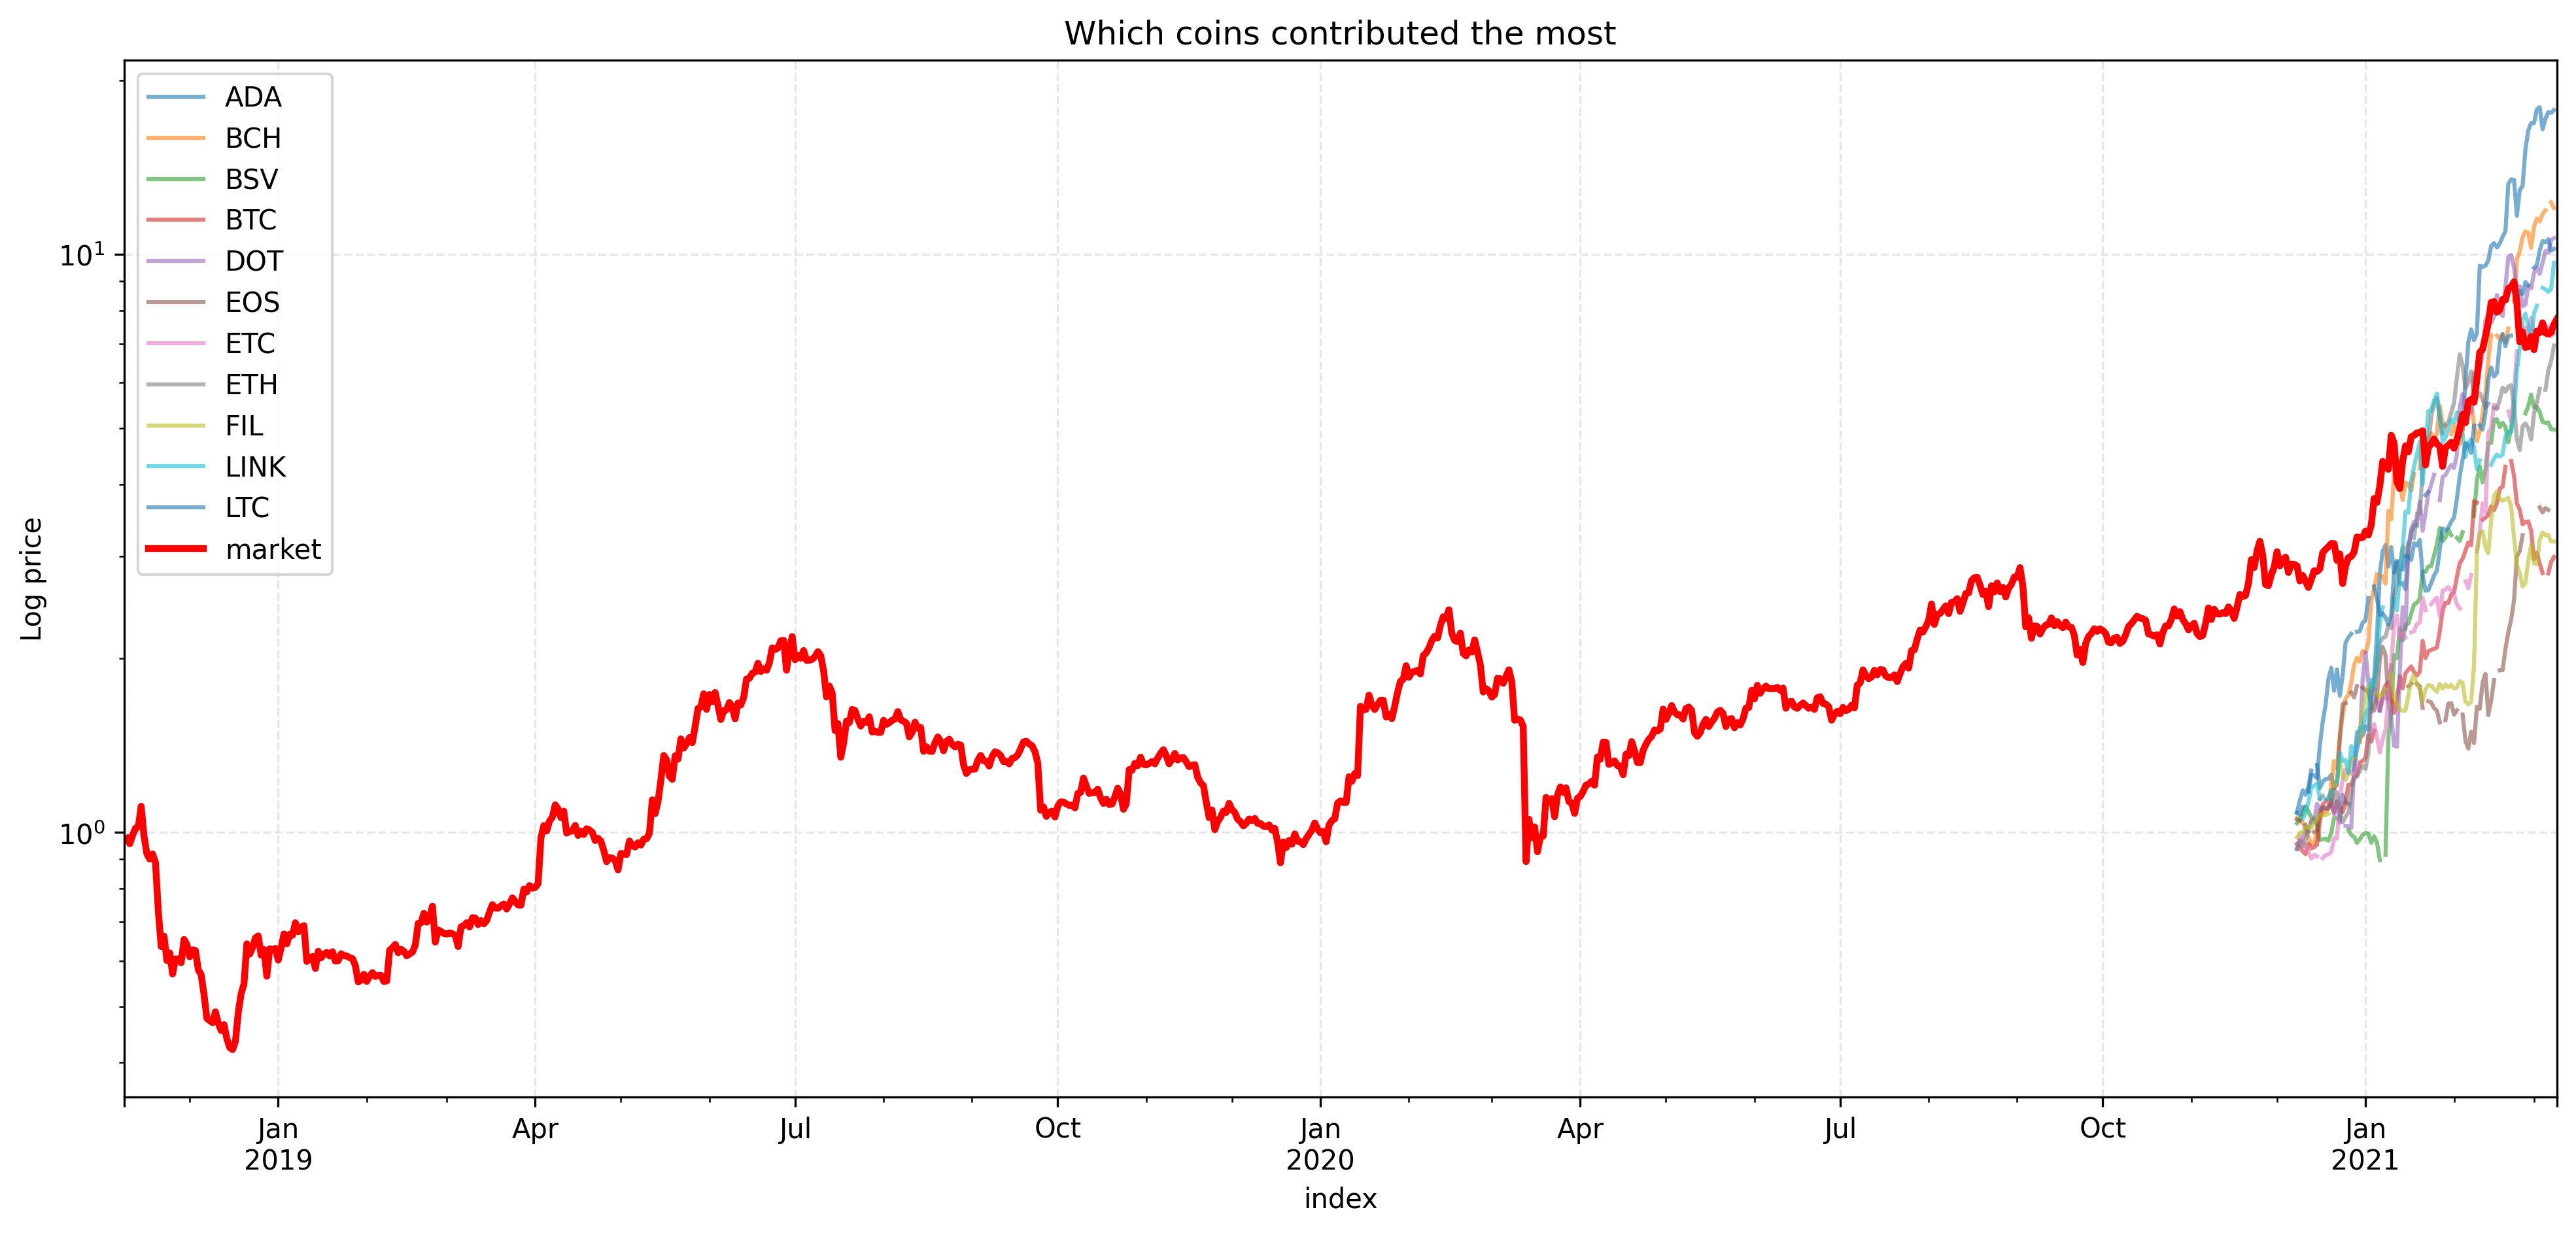

In [657]:
f, ax = plt.subplots(figsize=(16, 7), dpi=300)

cumulated_ = (1 + positions * all_price.pct_change().shift(-1)).cumprod()
cumulated_.plot(ax=ax, alpha=0.6);
market_price.loc[cumulated_.index].plot(ax=ax, label='market', c='red', lw=2.5)
plt.legend()
plt.grid(alpha=0.3, ls='--')

ax.set_title('Which coins contributed the most')
ax.set_ylabel('Log price')
ax.set_yscale('log')


plt.savefig('best_portfolio_contr.png')

In [549]:
from dataclasses import dataclass

@dataclass
class MeanTest:

    returns: float
    index: float
        
        
    mean_estimation: float = None
    mean_std: float = None
    mean_p_value: float = None
        
    independent_estimation: float = None
    independent_std: float = None
    independent_p_value: float = None
        
        
    def __post_init__(self):
        self.results = sm.regression.linear_model.OLS(self.returns, sm.tools.add_constant(self.index)).fit()
        self.mean_estimation = self.results.params['const']
        self.mean_std = np.sqrt(self.results.cov_params()['const'])['const']
        self.mean_p_value = self.results.pvalues['const']

        
        if 'excess' in self.results.params.index:
            self.independent_estimation = self.results.params['excess']
            self.independent_std = np.sqrt(self.results.cov_params()['excess'])['excess']
            self.independent_p_value = self.results.pvalues['excess']
        
        if 'CCMIX' in self.results.params.index:
            self.independent_estimation = self.results.params['CCMIX']
            self.independent_std = np.sqrt(self.results.cov_params()['CCMIX'])['CCMIX']
            self.independent_p_value = self.results.pvalues['CCMIX']
          
        
@dataclass
class DMBeta:
    returns: None
    market: None
        
    alpha: None = None
    beta: None = None
    upside_market_beta: None = None
        
    alpha_p: None = None
    beta_p: None = None
    upside_market_beta_p: None = None

    
    
    def __post_init__(self):
        self.results = sm.regression.linear_model.OLS(self.returns, sm.tools.add_constant(self.market)).fit()
        self.alpha, self.beta, self.upside_market_beta = self.results.params
        self.alpha_p, self.beta_p, self.upside_market_beta_p = self.results.pvalues


        
# Percentage winning trades
def get_percentage_winning_trades(returns):
    return returns[returns >= 0].count() / (returns[returns < 0].count() + returns[returns >= 0].count())


# Average return per trade
def get_average_return_per_trade(returns):
    return returns.mean()
    
    
    
@dataclass
class PerformanceStats:
    symbol: str
    returns: float 
    risk_free: float 
    
    sharpe: float = None
    winning_trades: int = None
    net_profit: float = None
    average_return_per_trade: float = None
    
        
        
    def __post_init__(self):
        self.winning_trades = get_percentage_winning_trades(self.returns)
        self.average_return_per_trade = get_average_return_per_trade(self.returns)
        
        self.sharpe = np.mean(self.returns - self.risk_free) / np.std(self.returns - self.risk_free)

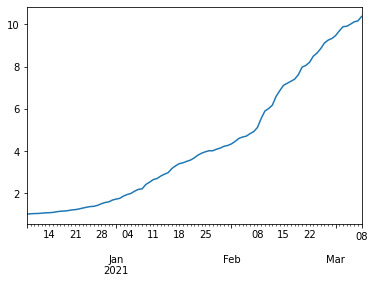

In [579]:
all_returns.T.iloc[:, -1].cumprod().dropna().plot()

In [568]:

for i in range(1, 5):
    returns = all_returns.T.iloc[:, -i].dropna() - 1
    res = PerformanceStats(returns=returns, risk_free=risk_free.loc[returns.index, :]['risk_free'], symbol='')
    print(i, f"|winrate: {round(res.winning_trades, 3)} | sharpe:{round(res.sharpe, 3)} | avg r per trade: {round(res.average_return_per_trade, 3)}")
    
    

1 |winrate: 0.989 | sharpe:1.444 | avg r per trade: 0.026
2 |winrate: 0.986 | sharpe:1.213 | avg r per trade: 0.023
3 |winrate: 0.968 | sharpe:0.638 | avg r per trade: 0.019
4 |winrate: 0.967 | sharpe:0.44 | avg r per trade: 0.022


In [565]:
for i in range(1, 5):
    returns = all_returns.T.iloc[:, -i].dropna() - 1
    market_return = ccmix_index.loc[returns.index]['CCMIX'].pct_change().fillna(0)
    risk_free_ = risk_free['risk_free'].loc[market_return.index]
    excess_return = market_return - risk_free_
    excess_return.name = 'excess'


    results = MeanTest(returns=returns - risk_free.loc[returns.index]['risk_free'] / 100,
             index=excess_return) 

    print(i, f' | alpha: {round(results.mean_estimation, 3)} p: {round(results.mean_p_value, 3)}| beta: {round(results.independent_estimation, 3)} p: {round(results.independent_p_value, 3)}|')
    
    
    

1  | alpha: 0.026 p: 0.0| beta: 0.046 p: 0.234|
2  | alpha: 0.022 p: 0.0| beta: 0.067 p: 0.037|
3  | alpha: 0.019 p: 0.0| beta: 0.113 p: 0.0|
4  | alpha: 0.023 p: 0.0| beta: 0.141 p: 0.0|


In [566]:
for i in range(1, 5):
    returns = all_returns.T.iloc[:, -i].dropna() - 1
    market_return = ccmix_index.loc[returns.index][['return', 'dummy']]
    market_return['return'] = market_return['return'] - risk_free_

    results = DMBeta(returns=returns - risk_free.loc[returns.index]['risk_free'] / 100, market=market_return)

    print(i, f' | alpha: {round(results.alpha, 3)}, p {round(results.alpha_p, 4)} | beta: {round(results.beta, 3)}, p {round(results.alpha_p, 4)} | upside: {round(results.upside_market_beta, 3)} p {round(results.upside_market_beta_p, 3)}')
    
    
    
    

1  | alpha: 0.015, p 0.0003 | beta: 0.054, p 0.0003 | upside: 0.014 p 0.003
2  | alpha: 0.016, p 0.0 | beta: 0.063, p 0.0 | upside: 0.008 p 0.004
3  | alpha: 0.014, p 0.0 | beta: 0.102, p 0.0 | upside: 0.008 p 0.0
4  | alpha: 0.017, p 0.0 | beta: 0.129, p 0.0 | upside: 0.009 p 0.0


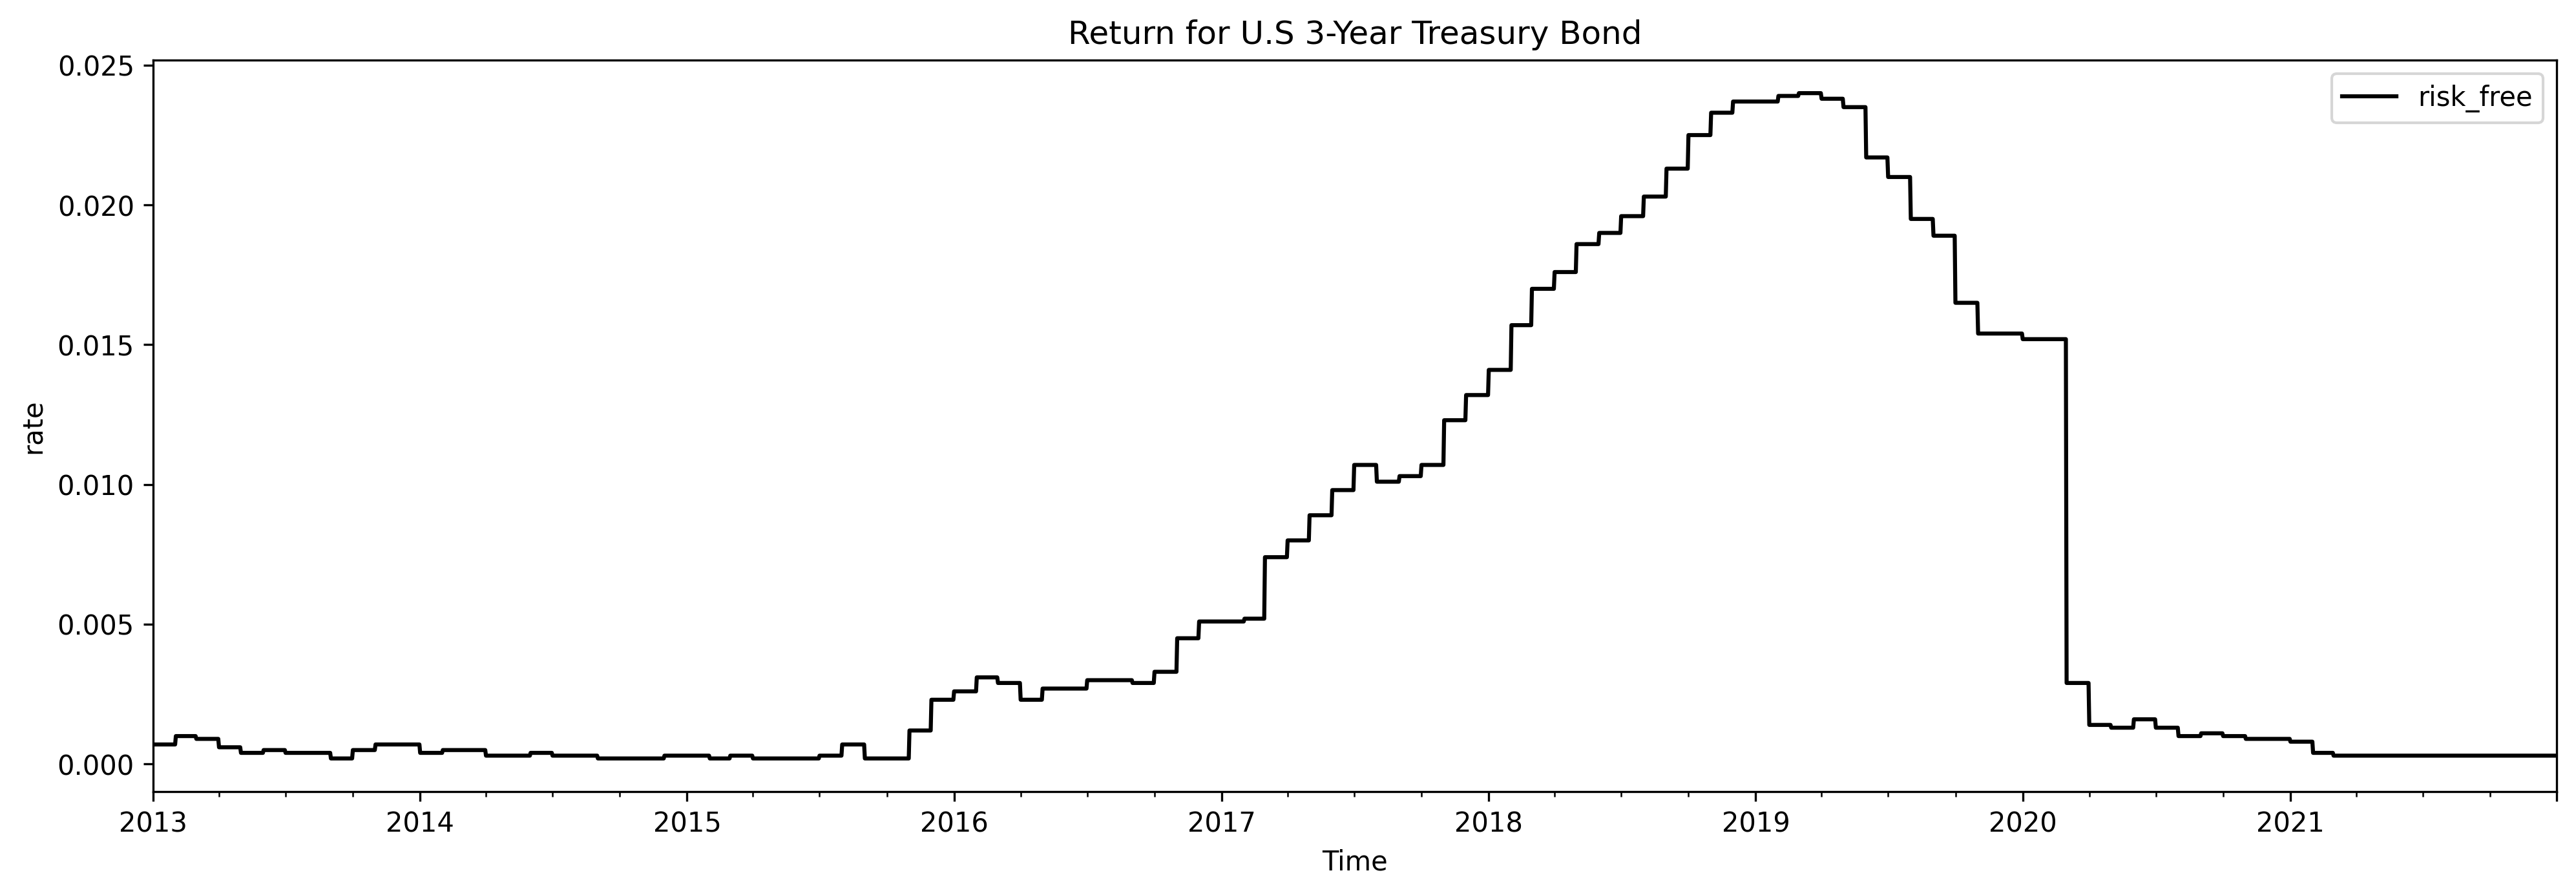

In [381]:
f, ax = plt.subplots(figsize=(16, 5), dpi=300)

ax.set_title('Return for U.S 3-Year Treasury Bond')
ax.set_xlabel('Time')
ax.set_ylabel('rate')
risk_free.plot(ax=ax, color='black')
plt.savefig('imgs/rf.png')

### Бонус

In [313]:
import statsmodels as sm

In [314]:
all_carry = pivot(futures_huobi[futures_huobi['length'] == '2quarter'])
all_price =  pivot(spot, 'price').loc[all_carry.index, all_carry.columns]

In [315]:
carry_ = (1 + all_carry['ADA']).cumprod().dropna().iloc[:-20]
cur_price = all_price['ADA'].loc[carry_.index]
carry_.name = 'carry'
cur_price.name = 'spot'
all_price_ = all_price['ADA'].shift(-1).loc[carry_.index]

In [316]:
X = sm.tools.add_constant(pd.concat([carry_, cur_price], axis=1))

model = sm.regression.linear_model.OLS(all_price_, X).fit()

In [317]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ADA   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 1.190e+04
Date:                Tue, 04 May 2021   Prob (F-statistic):          1.19e-208
Time:                        13:47:18   Log-Likelihood:                 545.41
No. Observations:                 203   AIC:                            -1085.
Df Residuals:                     200   BIC:                            -1075.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0439      0.004     10.624      0.000       0.036       0.052
carry          0.0037      0.000     12.336      0.000       0.003       0.004
spot           0.5762      0.037     15.405      0.000       0.502       0.650
==============================================================================
Omnibus:                       73.277   Durbin-Watson:                   1.304
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              672.212
Skew:                           1.072   Prob(JB):                    1.07e-146
Kurtosis:                      11.653   Cond. No.                         789.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

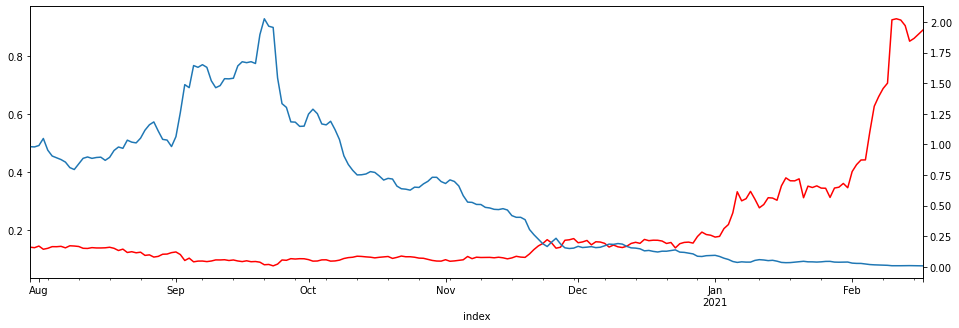

In [311]:
f, ax = plt.subplots(figsize=(16,5))

ax2= ax.twinx()

all_price_.plot(ax=ax, c='r')
carry_.plot(ax=ax2)

KeyError: 'ETC'

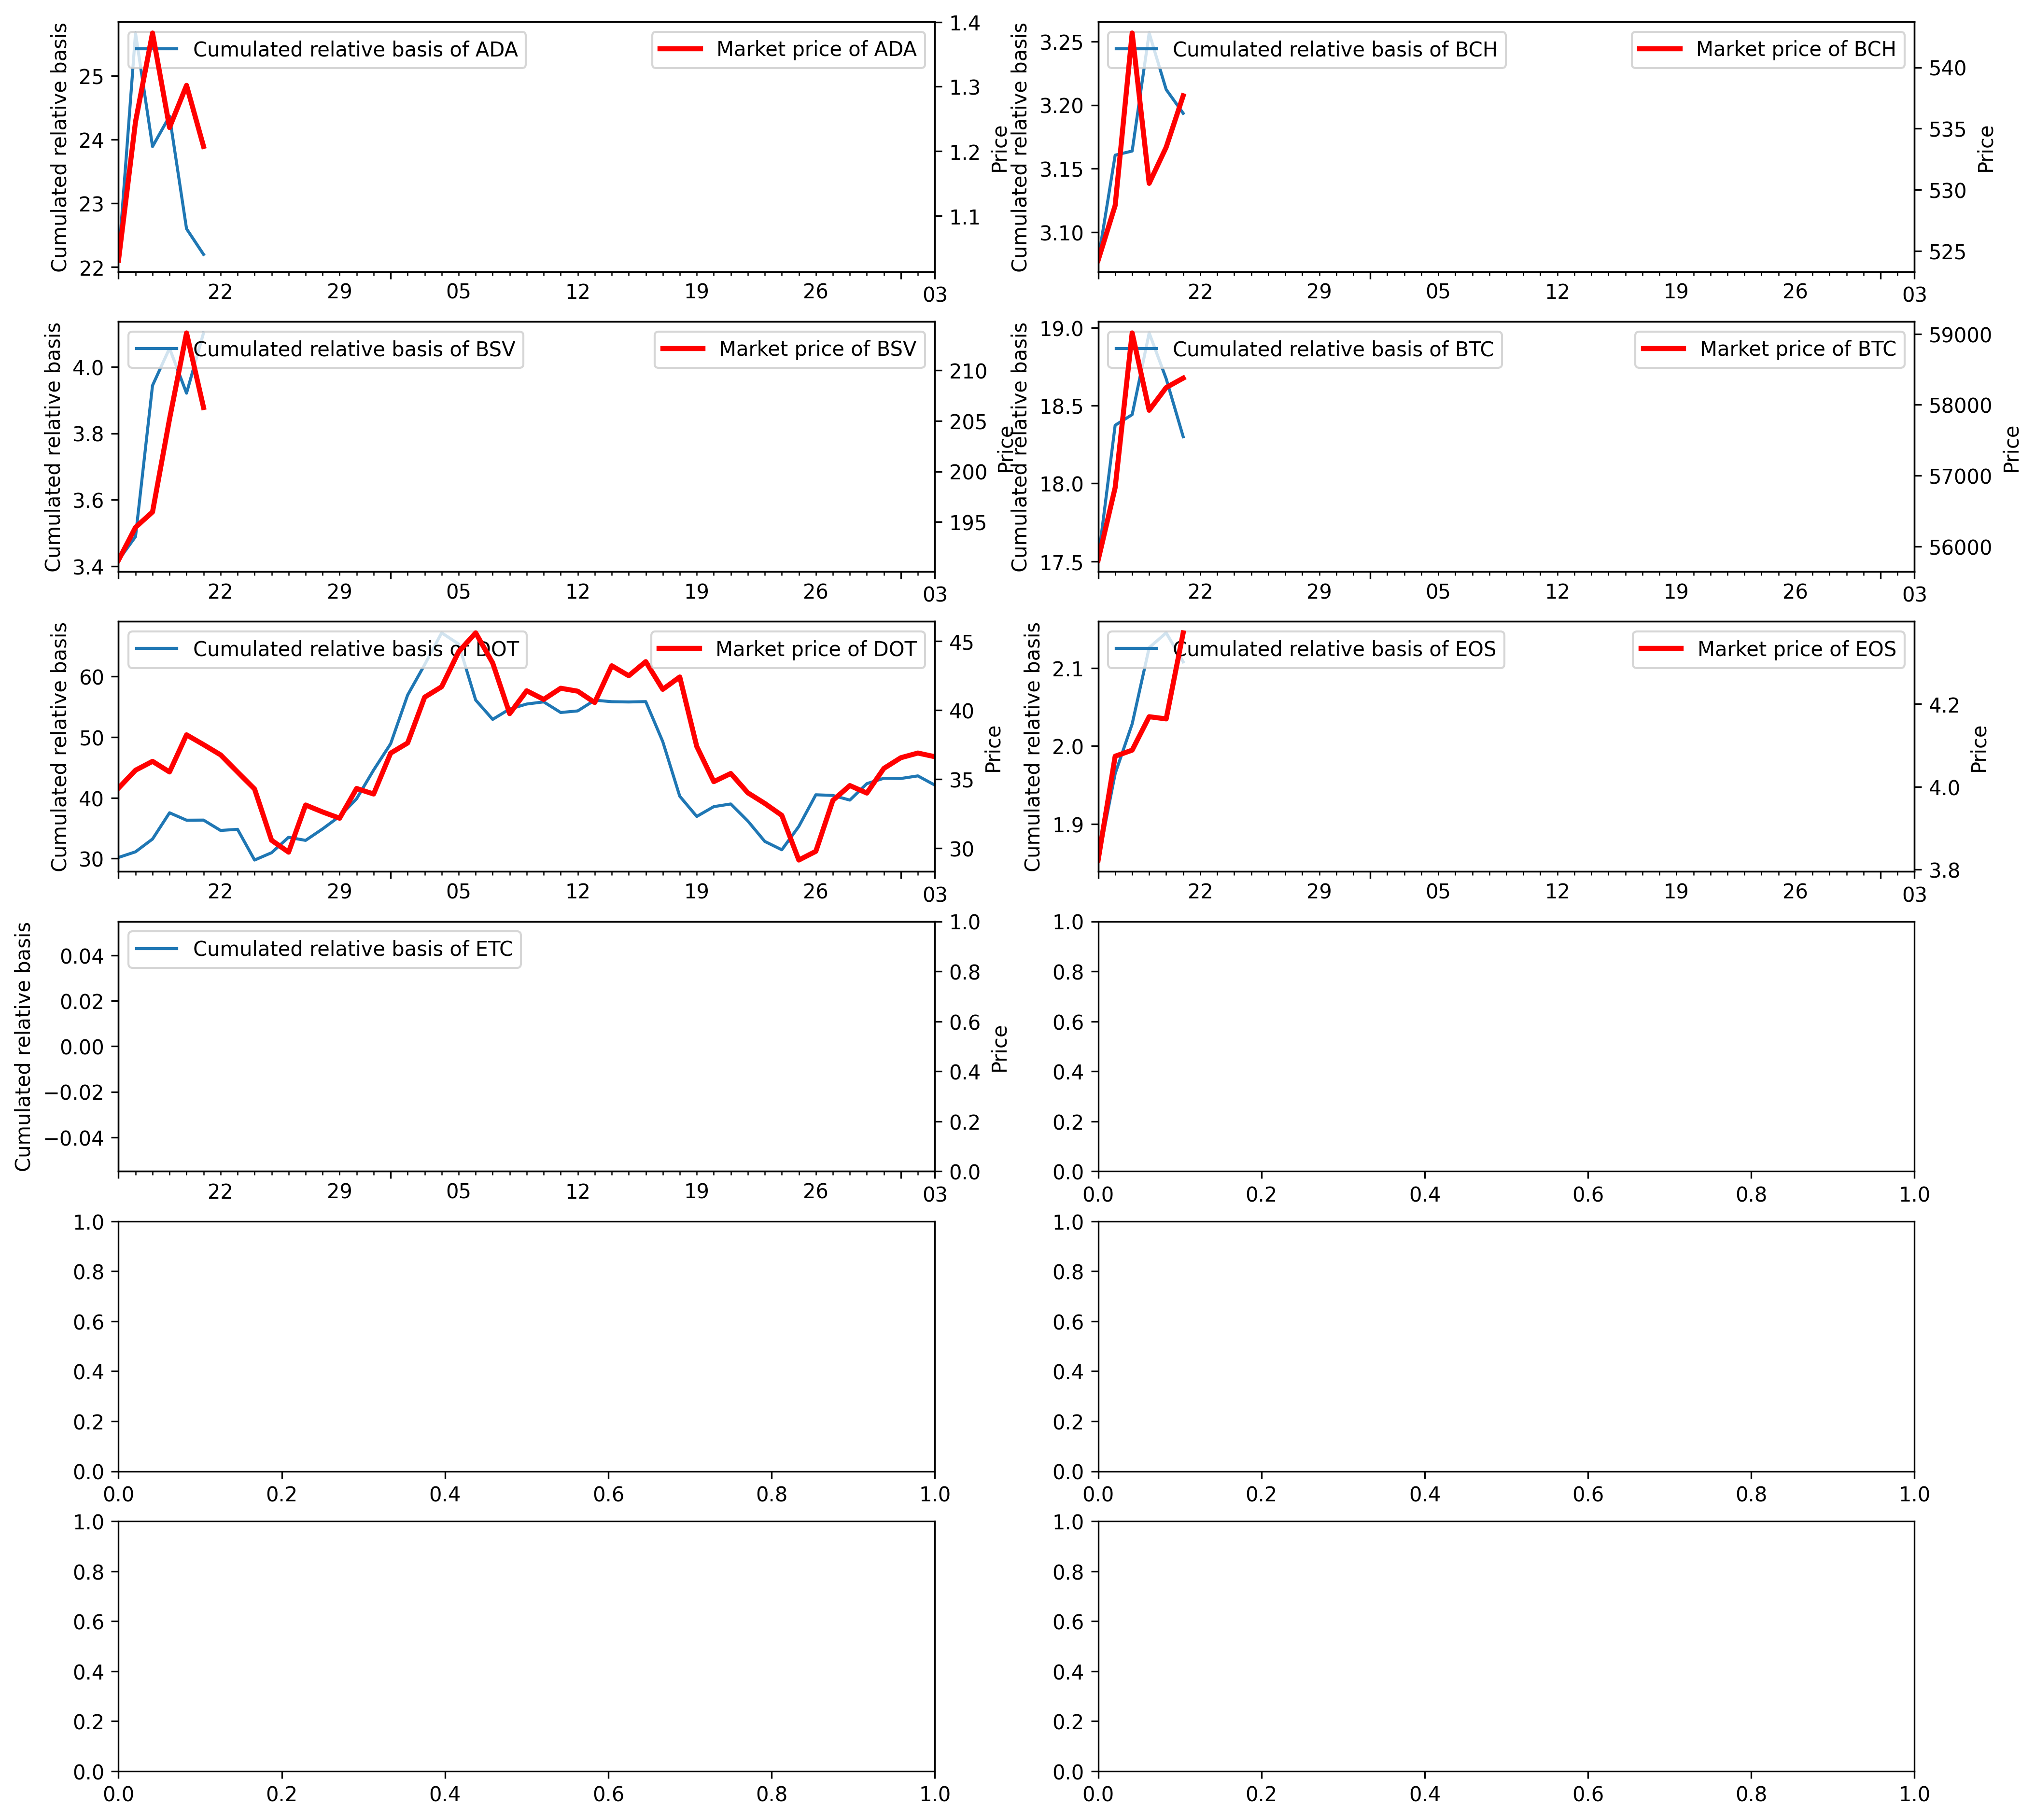

In [32]:
f, ax = plt.subplots(nrows=6, ncols=2, figsize=(16, 16), dpi=300)


for rows_n, row in enumerate([['ADA', 'BCH'], ['BSV', 'BTC'], ['DOT', 'EOS'], ['ETC', 'ETH'], ['FIL', 'LINK'], ['LTC']]):
    for symbol_n, symbol in enumerate(row):
        
        from_ = -50
        to = -1
        
        ax[rows_n][symbol_n].set_ylabel('Cumulated relative basis')
        (1 + all_carry).cumprod().iloc[from_: to, :][symbol].plot(ax=ax[rows_n][symbol_n], label=f'Cumulated relative basis of {symbol}')
        ax[rows_n][symbol_n].legend(loc='upper left')
        ax2 = ax[rows_n][symbol_n].twinx()
        ax2.set_ylabel('Price')

        all_price.iloc[from_: to, :][symbol].plot(ax=ax2, c='r', lw='2.5', label=f'Market price of {symbol}')
        ax2.legend(loc='upper right')


ax[5][1].remove()  
plt.tight_layout()

plt.savefig('imgs/cumulated_relative_basis.png')



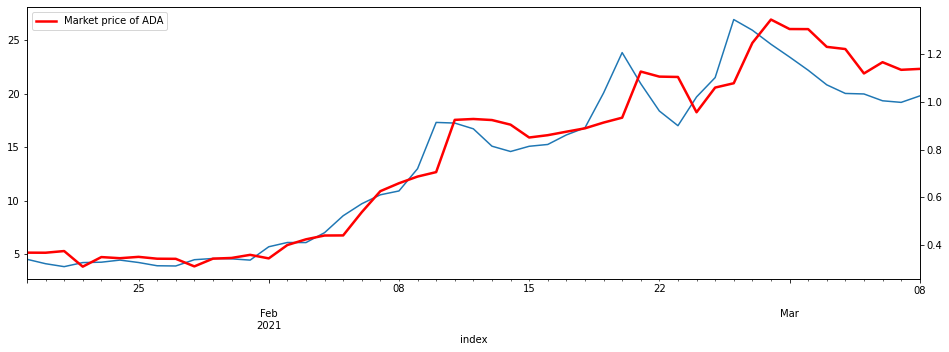

In [207]:
# Вот тут полный разъеб

f, ax = plt.subplots(figsize=(16,5))

from_ = -50
to = -1
symbol = 'ADA'

(1 + all_carry).cumprod().iloc[from_: to, :][symbol].plot(ax=ax, label='Factor')
ax2 = ax.twinx()
all_price.iloc[from_: to, :][symbol].plot(ax=ax2, c='r', lw='2.5', label=f'Market price of {symbol}')


plt.legend()

In [221]:
all_carry['ADA'].dropna().describe()

count    223.000000
mean       0.017546
std        0.090876
min       -0.251515
25%       -0.033322
50%       -0.001872
75%        0.046149
max        0.399822
Name: ADA, dtype: float64